# Part 1: EDA

**1. Overview of dataset [15%]**
a. Summarize the background of the dataset.
b. State the size of the dataset.
c. For each variable, describe what it represents and its data type (numerical or categorical).

**2. Data pre-processing [35%]**
a. For each variable, determine the percentage of missing data. For any column with missing data, describe how you resolve the issue. Clearly state any assumption you made.
b. For each variable, identify outliers (if any) and describe how you resolve the issue. Clearly state any assumption you made.
c. For categorical variables, perform the necessary encoding.

**3. Exploratory analysis and visualization [50%]**
a. For each variable, provide relevant summary statistics.
b. For each variable, provide an appropriate visualisation depicting the distribution of its values, and summarize any key observation(s) you made.
c. Perform bi-variate analyses on the variables. You do not need to analyse every pair; only focus on the pairs you believe are worth investigating and explain your choices. For each pair, describe the relationship between the two variables. Use appropriate statistical methods and/or visualization.

If applicable, corresponding codes that are reproducible (i.e., they produce output consistent with your answers), and well documented (in the form of comments and markdown cells).

In [76]:
# Imported libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Reading of Dataset

In [77]:
df = pd.read_csv("employee.csv")
df

,Date,Emp_ID,Age,Gender,City,Education,Salary,Join_Date,Last_Work_Date,Join_Designation,Designation,Total_Sales_Acquired,Quarterly_Rating
0,1/3/2016,1,28,Male,C23,Master,57387,24/12/2015,11/3/2016,1.0,1,1715580,2
1,1/12/2017,2,31,Male,C7,Master,67016,6/11/2017,NaN,NaN,2,0,1
2,1/4/2017,4,43,Male,C13,Master,65603,7/12/2016,27/4/2017,2.0,2,350000,1
3,1/3/2016,5,29,Male,C9,College,46368,9/1/2016,7/3/2016,1.0,1,120360,1
4,1/12/2017,6,31,Female,C11,Bachelor,80874,31/7/2017,NaN,3.0,3,1265000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,1/12/2017,2784,34,Male,C24,College,82815,15/10/2012,NaN,2.0,3,21748820,4
2377,1/10/2017,2785,34,Female,C9,College,12105,28/8/2017,28/10/2017,1.0,1,0,1
2378,1/9/2016,2786,45,Male,C19,College,35370,31/7/2015,22/9/2016,2.0,2,2815090,1
2379,1/6/2016,2787,28,Female,C20,Master,69498,21/7/2015,20/6/2016,1.0,1,977830,1


## 1. Overview of dataset

### a. Summarize the background of the dataset.
The dataset contains HR data related to a sales team. Specifically the dataset captures employees’ information at the beginning of each month, including if the employee quit in that given month, total sales acquired so far in his/her career and his/her latest quarterly rating. The dataset contains 2381 rows and 13 columns.

| Column Name | Description | Type | Details |
| ----------- | ----------- | ---- | ------- |
| Date | Record capture date | Categorical | Date in format DD/MM/YYYY |
| Emp_ID | Employee ID | Categorical |
| Age | Age | Numerical |
| Gender | Gender | Categorical | "Male", "Female" |
| City | City where employee works | Categorical | "C1", "C2", ..., "C29" |
| Education | Highest education level of employee | Categorical | "College", "Bachelor", "Master" |
| Salary | Last drawn salary | Numerical |
| Join_Date | Date of joining the sales team | Categorical | Date in format DD/MM/YYYY |
| Last_Work_Date | Last working date with the sales team | Categorical | Date in format DD/MM/YYYY. If employee does not quit in the given month where record is captured, the field would be empty (NaN). |
| Join_Designation | Designation level when first joined | Categorical | 1, 2, 3, 4, 5. |
| Designation | Designation level at the time record is captured | Categorical | 1, 2, 3, 4, 5 |
| Total_Sales_Acquired | Total sales generated by employee since joining the team | Numerical |
| Quarterly_Rating | Latest quarterly performance rating | Categorical | 1, 2, 3, 4 |



In [78]:
# get rows and columns (size) of dataframe
n_rows, n_cols = df.shape

print(f"Number of rows: {n_rows}")
print(f"Number of columns: {n_cols}")

Number of rows: 2381
Number of columns: 13


In [79]:
# get datatype of attributes/features
df.dtypes

Date                     object
Emp_ID                    int64
Age                       int64
Gender                   object
City                     object
Education                object
Salary                    int64
Join_Date                object
Last_Work_Date           object
Join_Designation        float64
Designation               int64
Total_Sales_Acquired      int64
Quarterly_Rating          int64
dtype: object

In [80]:
# analysing unique values of specific columns
genders = df["Gender"].unique()
cities = df["City"].unique()
education_levels = df["Education"].unique()
join_designation_levels = df["Join_Designation"].unique()
designation_levels = df["Designation"].unique()
quarterly_ratings = df["Quarterly_Rating"].unique()

print(f"Possible values of 'Gender' attribute: {genders}")
print(f"Possible values of 'City' attribute: {cities}")
print(f"Possible values of 'Education' attribute: {education_levels}")
print(f"Possible values of 'Join_Designation' attribute: {join_designation_levels}")
print(f"Possible values of 'Designation' attribute: {designation_levels}")
print(f"Possible values of 'Quarterly_Rating' attribute: {quarterly_ratings}")

Possible values of 'Gender' attribute: ['Male' 'Female']
Possible values of 'City' attribute: ['C23' 'C7' 'C13' 'C9' 'C11' 'C2' 'C19' 'C26' 'C20' 'C17' 'C29' 'C10'
 'C24' 'C14' 'C6' 'C28' 'C5' 'C18' 'C27' 'C15' 'C8' 'C25' 'C21' 'C1' 'C4'
 'C3' 'C16' 'C22' 'C12']
Possible values of 'Education' attribute: ['Master' 'College' 'Bachelor']
Possible values of 'Join_Designation' attribute: [ 1. nan  2.  3.  4.  5.]
Possible values of 'Designation' attribute: [1 2 3 4 5]
Possible values of 'Quarterly_Rating' attribute: [2 1 4 3]


## 2. Data pre-processing

In [81]:
# number of available data
df.count()

Date                    2381
Emp_ID                  2381
Age                     2381
Gender                  2381
City                    2381
Education               2381
Salary                  2381
Join_Date               2263
Last_Work_Date          1616
Join_Designation        2276
Designation             2381
Total_Sales_Acquired    2381
Quarterly_Rating        2381
dtype: int64

In [82]:
# percentage of data missing per attribute
print("Percentage of data missing")

col = df.columns
i = 0
missing_data_col = []

for valid_data in df.count():
    print(col[i], end=" = ")
    per_missing = (1 - (valid_data/n_rows))*100
    print(f"{per_missing : .2f}%")

    if per_missing > 0:
        missing_data_col.append(col[i])
        
    i += 1
print()

# print all column names of columns with missing data
print("Columns with missing data: " + str(missing_data_col))

Percentage of data missing
Date =  0.00%
Emp_ID =  0.00%
Age =  0.00%
Gender =  0.00%
City =  0.00%
Education =  0.00%
Salary =  0.00%
Join_Date =  4.96%
Last_Work_Date =  32.13%
Join_Designation =  4.41%
Designation =  0.00%
Total_Sales_Acquired =  0.00%
Quarterly_Rating =  0.00%

Columns with missing data: ['Join_Date', 'Last_Work_Date', 'Join_Designation']


### Missing Data
| Column Name | Percentage Missing | Resolution Technique | Assumptions |
| ----------- | ------------------ | -------------------- | ----------- |
| Last_Work_Date | 32.13% | Impute NaN values as the date in the "Date" attribute and Impute a new attribute "Current_Staff" with those that have NaN values initialised as "Yes" and those that have Last_Work_Date as "No". | Fields with NaN values suggest that the staff is still with the company. |
| Join_Date | 4.96% | Impute NaN values as the average tenure of their salary group from their Last_Work_Date | There is a correlation between salary and the tenure length of a worker in the company. |
| Join_Designation | 4.41% | Impute the NaN values as 1. | All workers begin at the lowest Designation level when they joined the company. |

In [83]:
# Resolving Last_Work_Date
print(f"Last_Work_Date has been resolved: {df["Last_Work_Date"].count() == n_rows}")
df["Current_Staff"] = "No"
df.loc[df["Last_Work_Date"].isna(), "Current_Staff"] = "Yes"
df.loc[df["Last_Work_Date"].isna(), "Last_Work_Date"] = df["Date"]
print(f"Last_Work_Date has been resolved: {df["Last_Work_Date"].count() == n_rows}")

Last_Work_Date has been resolved: False
Last_Work_Date has been resolved: True


In [84]:
from datetime import datetime
print(f"Join_Date has been resolved: {df["Join_Date"].count() == n_rows}")

# Convert date columns to datetime
df['Join_Date'] = pd.to_datetime(df['Join_Date'], format='%d/%m/%Y', errors='coerce')
df['Last_Work_Date'] = pd.to_datetime(df['Last_Work_Date'], format='%d/%m/%Y', errors='coerce')

# Filter employees with missing Join_Date
missing_join_df = df[df['Join_Date'].isna()].copy()

# Filter employees with both Join_Date and Last_Work_Date
valid_join_df = df[df['Join_Date'].notna() & df['Last_Work_Date'].notna()].copy()

# Calculate tenure in days for employees with valid join and last work dates
valid_join_df.loc[:, 'Tenure'] = (valid_join_df['Last_Work_Date'] - valid_join_df['Join_Date']).dt.days

# Group by salary ranges (e.g., every 10,000)
valid_join_df.loc[:, 'Salary_Range'] = pd.cut(valid_join_df['Salary'], bins=range(0, 150000, 10000))

# Calculate average tenure for each salary range
avg_tenure_by_salary = valid_join_df.groupby('Salary_Range', observed=True)['Tenure'].mean()

# Function to estimate join date based on salary range
def estimate_join_date(row):
    salary_range = pd.cut([row['Salary']], bins=range(0, 150000, 10000))[0]
    if salary_range in avg_tenure_by_salary:
        avg_tenure = avg_tenure_by_salary[salary_range]
        if pd.notna(row['Last_Work_Date']):
            estimated_join_date = row['Last_Work_Date'] - pd.Timedelta(days=avg_tenure)
            return estimated_join_date
    return row['Last_Work_Date'] - pd.DateOffset(years=1)  # Default fallback

# Update only the rows with missing join dates
df.loc[missing_join_df.index, 'Join_Date'] = missing_join_df.apply(estimate_join_date, axis=1)

# Convert the estimated join date back to the original format
df['Join_Date'] = df['Join_Date'].dt.strftime('%d/%m/%Y')
df['Last_Work_Date'] = df['Last_Work_Date'].dt.strftime('%d/%m/%Y')

# Print the updated DataFrame
# print(df[['Emp_ID', 'Salary', 'Date', 'Join_Date']])
# print(df['Join_Date'].count() / df['Emp_ID'].count() * 100)

# Verify all Join_Date values are filled
print(f"Join_Date has been resolved: {df['Join_Date'].count() == n_rows}")

Join_Date has been resolved: False
Join_Date has been resolved: True


In [85]:
# Resolving Join_Designation
print(f"Join_Designation has been resolved: {df["Join_Designation"].count() == n_rows}")
df["Join_Designation"] = df["Join_Designation"].replace(np.nan, 1)

print(f"Join_Designation has been resolved: {df["Join_Designation"].count() == n_rows}")

Join_Designation has been resolved: False
Join_Designation has been resolved: True


In [86]:
# check if all NaN values have been handled

df.count()

Date                    2381
Emp_ID                  2381
Age                     2381
Gender                  2381
City                    2381
Education               2381
Salary                  2381
Join_Date               2381
Last_Work_Date          2381
Join_Designation        2381
Designation             2381
Total_Sales_Acquired    2381
Quarterly_Rating        2381
Current_Staff           2381
dtype: int64

### Invalid Data Identification

We will now be checking if there are any outliers in the dataset provided. 

We will do so by checking the min and max value of each variables and see if there are any values that is outside of the norm of each variable.

In [87]:
# checking the min of each variable
print("Min value of each variable\n")
col = df.columns
for i in range(len(df.columns)):
    print(col[i], end=" = ")
    min_value = df[col[i]].min()
    print(str(min_value))


Min value of each variable

Date = 1/1/2016
Emp_ID = 1
Age = 21
Gender = Female
City = C1
Education = Bachelor
Salary = 10747
Join_Date = 01/01/2015
Last_Work_Date = 01/01/2016
Join_Designation = 1.0
Designation = 1
Total_Sales_Acquired = -1385530
Quarterly_Rating = 1
Current_Staff = No


As seen from the results, the minimum value of the Total_Sales_Acquired attribute is negative. This is an outlier as we assumed that employees can only sales or no sales at all. There should not be employees that make negative sales.

Hence, we will be removing all the employees that are making negative sales.

In [88]:
# checking the number of employees that make negative sales
negative_sales = df.loc[df["Total_Sales_Acquired"] < 0, "Total_Sales_Acquired"].count()
print("Employees with negative sales: " + str(negative_sales))
print("Percentage of employees with negative sales out of all employees: " + str((negative_sales / df['Total_Sales_Acquired'].count())*100) + "%")

# removing the aforementioned employees from the data
df = df.drop(df[df['Total_Sales_Acquired'] < 0].index)

# check again
print("Updated employees with negative sales: " + str(df.loc[df["Total_Sales_Acquired"] < 0, "Total_Sales_Acquired"].count()))
print("Min. Total Sales Acquired: " + str(df["Total_Sales_Acquired"].min()))

Employees with negative sales: 10
Percentage of employees with negative sales out of all employees: 0.41999160016799664%
Updated employees with negative sales: 0
Min. Total Sales Acquired: 0


We will now be checking the max value of each variables and see if there are any values that is outside of the norm of each variable.

In [89]:
# checking the max of each variable
print("Max value of each variable\n")
col = df.columns
for i in range(len(df.columns)):
    print(col[i], end=" = ")
    min_value = df[col[i]].max()
    print(str(min_value))

Max value of each variable

Date = 1/9/2017
Emp_ID = 2788
Age = 58
Gender = Male
City = C9
Education = Master
Salary = 188418
Join_Date = 31/12/2015
Last_Work_Date = 31/12/2016
Join_Designation = 5.0
Designation = 5
Total_Sales_Acquired = 95331060
Quarterly_Rating = 4
Current_Staff = Yes


In [90]:
# number of available data
print(df.count())
df

Date                    2371
Emp_ID                  2371
Age                     2371
Gender                  2371
City                    2371
Education               2371
Salary                  2371
Join_Date               2371
Last_Work_Date          2371
Join_Designation        2371
Designation             2371
Total_Sales_Acquired    2371
Quarterly_Rating        2371
Current_Staff           2371
dtype: int64


,Date,Emp_ID,Age,Gender,City,Education,Salary,Join_Date,Last_Work_Date,Join_Designation,Designation,Total_Sales_Acquired,Quarterly_Rating,Current_Staff
0,1/3/2016,1,28,Male,C23,Master,57387,24/12/2015,11/03/2016,1.0,1,1715580,2,No
1,1/12/2017,2,31,Male,C7,Master,67016,06/11/2017,01/12/2017,1.0,2,0,1,Yes
2,1/4/2017,4,43,Male,C13,Master,65603,07/12/2016,27/04/2017,2.0,2,350000,1,No
3,1/3/2016,5,29,Male,C9,College,46368,09/01/2016,07/03/2016,1.0,1,120360,1,No
4,1/12/2017,6,31,Female,C11,Bachelor,80874,31/07/2017,01/12/2017,3.0,3,1265000,2,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,1/12/2017,2784,34,Male,C24,College,82815,15/10/2012,01/12/2017,2.0,3,21748820,4,Yes
2377,1/10/2017,2785,34,Female,C9,College,12105,28/08/2017,28/10/2017,1.0,1,0,1,No
2378,1/9/2016,2786,45,Male,C19,College,35370,31/07/2015,22/09/2016,2.0,2,2815090,1,No
2379,1/6/2016,2787,28,Female,C20,Master,69498,21/07/2015,20/06/2016,1.0,1,977830,1,No


### How we resolved the invalid data

| Column Name | Problem | Percentage Invalid | Resolution Technique | Assumptions |
| ----------- | ------- | ------------------ | -------------------- | ----------- |
| Total_Sales_Acquired| Some of the records have Total_Sales_Acquired that are negative | 0.41999160016799664% | Since there are only 10 or 0.420% of the total records that show invalid data, we have decided to remove those records. | We assume that negative Total_Sales_Acquired is not possible, hence suggesting that the data is invalid. |

### Outlier Identification (MODIFIED)

We must now analyze the dataset provided, and identify the outliers from selected variables.

The selection process lies solely on intuition. For example, we chose age for there will, of course, be a possibility that an employee would be outside of the hiring norms.

All of these side, we chose three variables to analyze:
1. Age
2. Salary
3. Sales

For each variable, we identify the following:
1. 25th Quartile
2. 75th Quartile
3. Interquartile range (IQR)

And use the obtained information to identify the upper and lower boundaries. With these on hand, we can then identify the outliers by checking if the data goes beyond the boundaries.

In [91]:
## Age
# quantiles
AGEQ1 = df["Age"].quantile(0.25)
AGEQ3 = df["Age"].quantile(0.75)
AGEIQR = AGEQ3-AGEQ1

# boundaries
AGEUpper = AGEQ3+(1.5*AGEIQR)
AGELower = AGEQ1-(1.5*AGEIQR)
AGEOutlier = df[(df["Age"]<AGELower)|(df["Age"]>AGEUpper)]
print("AGE 25th Percentile:", AGEQ1)
print("Youngest employee:", df["Age"].min())
print("AGE 75th Percentile:", AGEQ3)
print("Oldest employee:", df["Age"].max())
print("AGE IQR:", AGEIQR)
print("Total amount of AGE Outliers:", len(AGEOutlier))

# this one prints everything idk how to pinpoint the employee ids only
# print("AGE Outliers", AGEOutlier)

AGE 25th Percentile: 29.0
Youngest employee: 21
AGE 75th Percentile: 37.0
Oldest employee: 58
AGE IQR: 8.0
Total amount of AGE Outliers: 25


In [92]:
## Salary
# quantiles
SALQ1 = df["Salary"].quantile(0.25)
SALQ3 = df["Salary"].quantile(0.75)
SALIQR = SALQ3-SALQ1

# boundaries
SALUpper = SALQ3+(1.5*SALIQR)
SALLower = SALQ1-(1.5*SALIQR)
SALOutlier = df[(df["Salary"]<SALLower)|(df["Salary"]>SALUpper)]
print("SALARY 25th Percentile: $", SALQ1)
print("Lowest salary: $", df["Salary"].min())
print("SALARY 75th Percentile: $", SALQ3)
print("Highest salary: $", df["Salary"].max())
print("Salary IQR: $", SALIQR)
print("Total amount of Salary Outliers:", len(SALOutlier))

# this one prints everything idk how to pinpoint the employee ids only
# print("Salary Outliers", SALOutlier)

SALARY 25th Percentile: $ 39111.5
Lowest salary: $ 10747
SALARY 75th Percentile: $ 75910.5
Highest salary: $ 188418
Salary IQR: $ 36799.0
Total amount of Salary Outliers: 49


In [93]:
## Salary
# quantiles

# need to filter again for zeroes if thats a concern
# i understand that negatives got removed
# this one includes zeroes

SALESQ1 = df["Total_Sales_Acquired"].quantile(0.25)
SALESQ3 = df["Total_Sales_Acquired"].quantile(0.75)
SALESIQR = SALESQ3-SALESQ1

# boundaries
SALESUpper = SALESQ3+(1.5*SALESIQR)
SALESLower = SALESQ1-(1.5*SALESIQR)
SALESOutlier = df[(df["Total_Sales_Acquired"]<SALESLower)|(df["Total_Sales_Acquired"]>SALESUpper)]
print("SALES 25th Percentile: $", SALESQ1)
print("Lowest sales: $", df["Total_Sales_Acquired"].min())
print("SALES 75th Percentile: $", SALESQ3)
print("Highest sales: $", df["Total_Sales_Acquired"].max())
print("Sales IQR: $", SALESIQR)
print("Total amount of Sales Outliers:", len(SALESOutlier))

# this one prints everything idk how to pinpoint the employee ids only
# print("Salary Outliers", SALOutlier)

SALES 25th Percentile: $ 0.0
Lowest sales: $ 0
SALES 75th Percentile: $ 4212320.0
Highest sales: $ 95331060
Sales IQR: $ 4212320.0
Total amount of Sales Outliers: 334


## 3. EDA and Visualisation

1. Univariate
- histogram for Total_Sales_Acquired
- histogram for Total_Sales_Acquired without employees with 0 sales
- donut chart for Designation_Level distribution
- pie chart for Quarterly_Rating distribution
- histogram for Salary distribution
- histogram for Age distribution
- pie chart for Gender distribution
- pie chart for Education level distribution 
- bar chart for City distribution 


2. Bivariate
- grouped boxplot for Salary against Education level
- grouped boxplot for Salary against designation
- grouped boxplot for Salary against Gender
- scatter plot for Salary against Age
- grouped boxplot for Total_Sales_Acquired and Gender
- scatter plot for Total_Sales_Acquired against Age
- scatter plot for Total_Sales_Acquired against Salary
- histogram for Total_Sales_Acquired by Designation_Level 
- histogram for Total_Sales_Acquired by Quarterly_Rating 

## Univariate Analysis

### Total_Sales_Acquired
With a large standard deviation, it goes to show that the spread of the Total_Sales_Acquired across all employees in the company is rather large. 

The histogram plot also suggests that employees either produce very little to no sales or a lot of sales. Perhaps this suggests that the company has a significant proportion of employees that are not involved in sales. For more meaningful analysis, it could perhaps be more useful to categorise the type of employees.

Alternatively, this might also indicates that some employees may be facing challenges or are underperforming. However, there is also a group of employees that achieved high sales reaching 10-18 which gives a clear difference between low and high performers.


In [94]:
# mean
print(f"Mean total sales acquired: {df["Total_Sales_Acquired"].mean() : .2f}")

# standard deviation
print(f"s.d. total sales acquired: {df["Total_Sales_Acquired"].std() : .2f}")

# min
print(f"Min total sales acquired: {df["Total_Sales_Acquired"].min() : .2f}")

# median 
print(f"Median total sales acquired: {df["Total_Sales_Acquired"].median() : .2f}")

# max
print(f"Max total sales acquired: {df["Total_Sales_Acquired"].max() : .2f}")

Mean total sales acquired:  4607118.99
s.d. total sales acquired:  9139247.53
Min total sales acquired:  0.00
Median total sales acquired:  834890.00
Max total sales acquired:  95331060.00


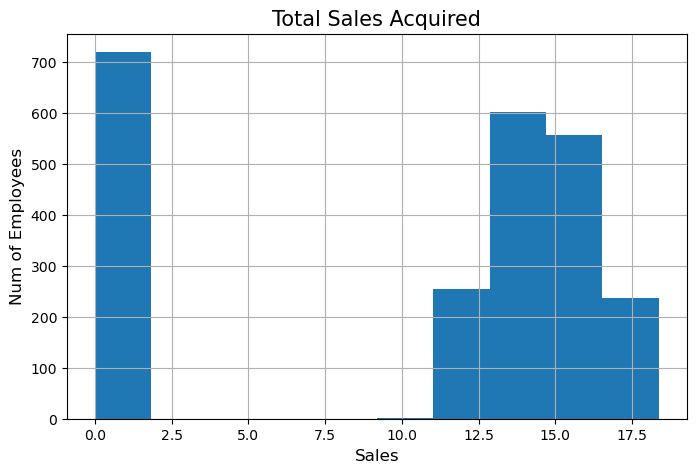

In [95]:
# Histogram of Total Sales Acquired
plt.figure(figsize=(8,5))
plt.title("Total Sales Acquired", fontsize=15)
plt.xlabel("Sales", fontsize=12)
plt.ylabel("Num of Employees", fontsize=12)
log_TotalSales = np.log1p(df.Total_Sales_Acquired)
log_TotalSales.hist(bins=10) 
plt.show()

### Total_Sales_Acquired without Employees with 0 sales

With the revelation that there are many employees that have 0 sales, we decided to do a total sales acquired analysis only on employees that has sales so that the insights gathered are more meaningful.

Excluding the 719 employees with 0 sales, the mean total sales is actually about 2 million more than previously analysed. This shows that the employees making sales are doing a much better job than previously analysed. Furthermore, with reference to the histogram, the total sales acquired does follow the a normal distribution. 

In [96]:
# number of employees with 0 sales
print("Number of employees with 0 sales: " + str(df.loc[df["Total_Sales_Acquired"] == 0, "Total_Sales_Acquired"].count()))

# mean
print(f"Mean total sales acquired: {df.loc[df["Total_Sales_Acquired"] > 0, "Total_Sales_Acquired"].mean() : .2f}")

# standard deviation
print(f"s.d. total sales acquired: {df.loc[df["Total_Sales_Acquired"] > 0, "Total_Sales_Acquired"].std() : .2f}")

# min
print(f"Min total sales acquired: {df.loc[df["Total_Sales_Acquired"] > 0, "Total_Sales_Acquired"].min() : .2f}")

# median 
print(f"Median total sales acquired: {df.loc[df["Total_Sales_Acquired"] > 0, "Total_Sales_Acquired"].median() : .2f}")

# max is the same as above

Number of employees with 0 sales: 719
Mean total sales acquired:  6612275.50
s.d. total sales acquired:  10326380.87
Min total sales acquired:  19580.00
Median total sales acquired:  2242080.00


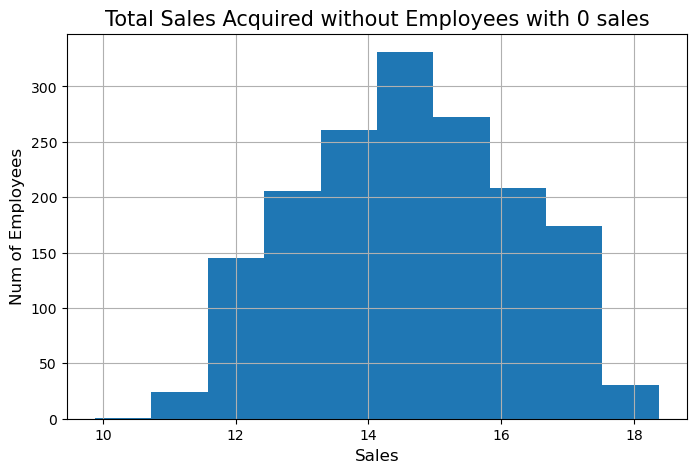

In [97]:
# Histogram of Total Sales Acquired
plt.figure(figsize=(8,5))
plt.title("Total Sales Acquired without Employees with 0 sales", fontsize=15)
plt.xlabel("Sales", fontsize=12)
plt.ylabel("Num of Employees", fontsize=12)
log_TotalSales = np.log1p(df.loc[df["Total_Sales_Acquired"] > 0, "Total_Sales_Acquired"])
log_TotalSales.hist(bins=10)  
plt.show()

### Designation_Level
It suggests that the Designation level 5 could correspond to the Directors of the company and with each Designation level in descending order suggesting a more junior level staff of the company. This is representative of a typical corporate organisational structure.

In [98]:
# mean
print(f"Mean designation level: {df["Designation"].mean() : .2f}")

# standard deviation
print(f"s.d. designation level: {df["Designation"].std() : .2f}")

# min
print("Min designation level: " + str(df["Designation"].min()))

# median 
print("Median designation level: " + str(df["Designation"].median()))

# max
print("Max designation level: " + str(df["Designation"].max()))



Mean designation level:  2.10
s.d. designation level:  0.94
Min designation level: 1
Median designation level: 2.0
Max designation level: 5


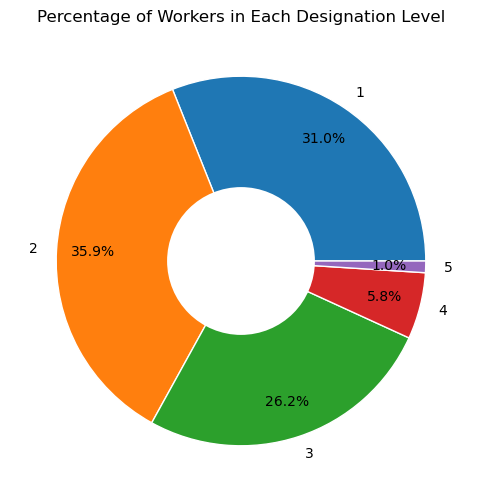

In [99]:
# Doughnut Chart showing the Percentage of Workers in Each Designation Level
plt.figure(figsize=(6, 6))
plt.pie(df["Designation"].value_counts().sort_index(), labels=df["Designation"].unique(), autopct='%1.1f%%', wedgeprops={'edgecolor': 'white'}, pctdistance=.8)

# Create a circle at the center to make it a doughnut
centre_circle = plt.Circle((0, 0), 0.40, fc='white')
plt.gca().add_artist(centre_circle)

# Title & Show Plot
plt.title("Percentage of Workers in Each Designation Level")
plt.show()

### Quarterly_Rating
The pie chart shows a breakdown of the proportion of employees in for each Quarterly_Rating band. 

Intuitively, this suggests that band 4 which makes up the smallest proportion of employees at 4.5% are the top performers for the quarter. A vast majority of employees are awarded band 1 at 73.2% of the all employees in the company.

This noticeable performance difference where a majority of employees received the lowest rating, might indicate widespread underperformance. The small number of employees with high ratings can also further suggest challenges in performance and lack of staff training.


In [100]:
# mean
print(f"Mean quarterly rating: {df["Quarterly_Rating"].mean() : .2f}")

# standard deviation
print(f"s.d. quarterly rating: {df["Quarterly_Rating"].std() : .2f}")

# min
print("Min quarterly rating: " + str(df["Quarterly_Rating"].min()))

# median 
print("Median quarterly rating: " + str(df["Quarterly_Rating"].median()))

# max
print("Max quarterly rating: " + str(df["Quarterly_Rating"].max()))

Mean quarterly rating:  1.43
s.d. quarterly rating:  0.81
Min quarterly rating: 1
Median quarterly rating: 1.0
Max quarterly rating: 4


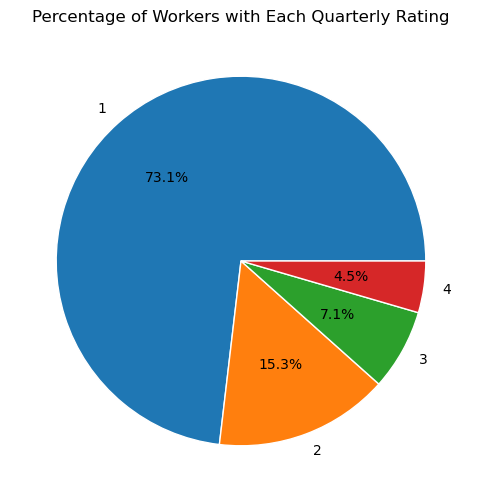

In [101]:
# Pie Chart showing the Percentage of Workers with Each Quarterly Rating
plt.figure(figsize=(6, 6))
plt.pie(df["Quarterly_Rating"].value_counts().sort_index(), labels=sorted(df["Quarterly_Rating"].unique()), autopct='%1.1f%%', wedgeprops={'edgecolor': 'white'}, pctdistance=.6)

# Title & Show Plot
plt.title("Percentage of Workers with Each Quarterly Rating")
plt.show()

### Salary of Employees
The mean salary of employees in the company is $59336.13. Based on the histogram, the distributions of salary of employees seem to follow a normal distribution.

In [102]:
print(f"Mean employee salary: {df['Salary'].mean() : .2f}")

print(f"s.d. employee salary: {df['Salary'].std() : .2f}")

# min
print("Min employee salary: " + str(df["Salary"].min()))

# median 
print("Median employee salary: " + str(df["Salary"].median()))

# max
print("Max employee salary: " + str(df["Salary"].max()))

Mean employee salary:  59359.14
s.d. employee salary:  28403.52
Min employee salary: 10747
Median employee salary: 55344.0
Max employee salary: 188418


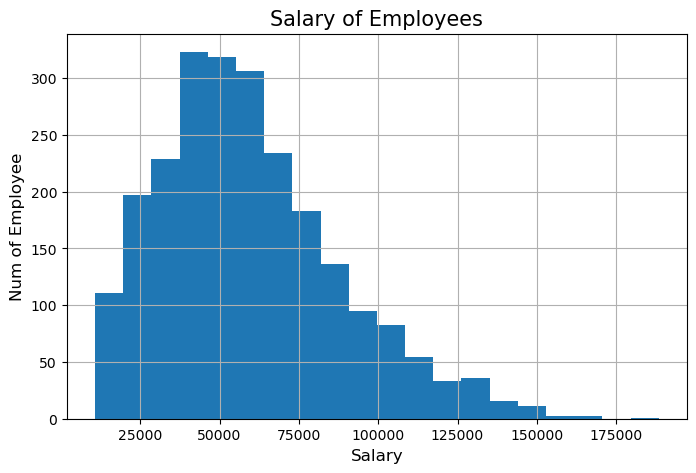

In [103]:
plt.figure(figsize=(8,5))
plt.title("Salary of Employees", fontsize=15)
plt.xlabel("Salary", fontsize=12)
plt.ylabel("Num of Employee", fontsize=12)
df["Salary"].hist(bins=20)  
plt.show()

### Age of Employees
Based on the histogram, it seems to imply that majority of the employees in the company are around 30 years of age. 

The mean age is 33.7 which suggests that the distribution of the age of employees tend more towards larger than 30 years of age than it does to less than 30 years of age.

In [104]:
print(f"Mean age of employee: {df['Age'].mean() : .0f}")

print(f"s.d. age of employee: {df['Age'].std() : .0f}")

# min
print("Min age of employee: " + str(df["Age"].min()))

# median 
print("Median age of employee: " + str(df["Age"].median()))

# max
print("Max age of employee: " + str(df["Age"].max()))

Mean age of employee:  34
s.d. age of employee:  6
Min age of employee: 21
Median age of employee: 33.0
Max age of employee: 58


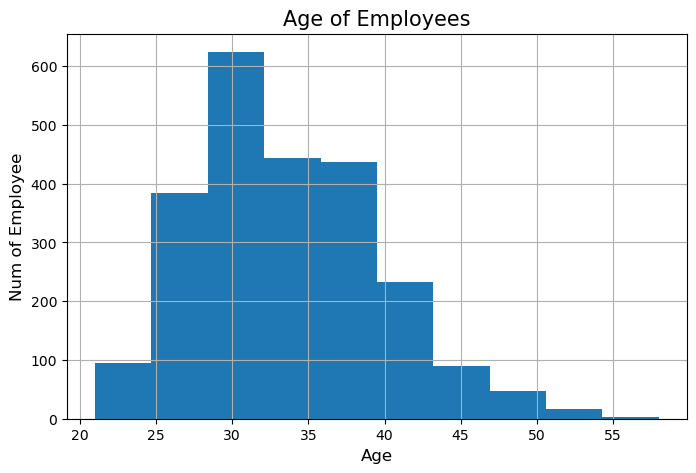

In [105]:
# Histogram for Age
plt.figure(figsize=(8,5))
plt.title("Age of Employees", fontsize=15)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Num of Employee", fontsize=12)
# log_Age = np.log1p(df.Age)
df["Age"].hist(bins=10)  
plt.show()

### Gender Distribution
The pie chart shows the gender distribution among employees, revealing that 59.0% of the workforce is male, while 41.0% is female.

This illustrates a small gender gap with males taking the majority. The male-dominated environment may also be caused by industry trends, workplace policies or societal factors. Furthermore, it may also indicate a bias in hiring male employees because of the job requirements that are aligned more with male employees.


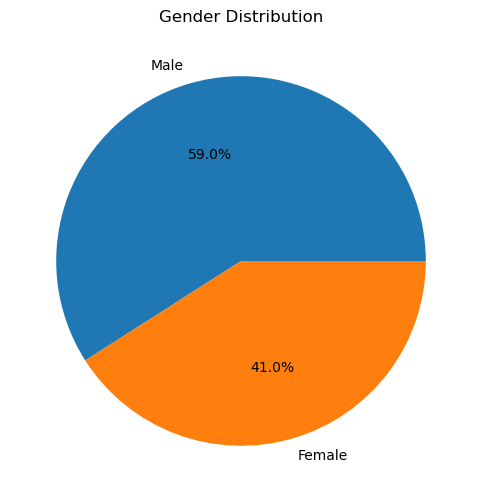

In [106]:
# Pie Chart showing the Gender Distribution of the company
x = df['Gender'].value_counts()
y = x.index
plt.figure(figsize=(6, 6)) #size
plt.pie(x, labels=y, autopct='%1.1f%%') #string format
plt.title("Gender Distribution")
plt.show()

### Education Distribution
The pie chart illustrates the distribution of education levels of employees.

With reference to the pie chart, there is a fairly balanced proportion across the three education categories. 

The nearly equal proportions indicate that the company has employees from an evenly distributed educational background.

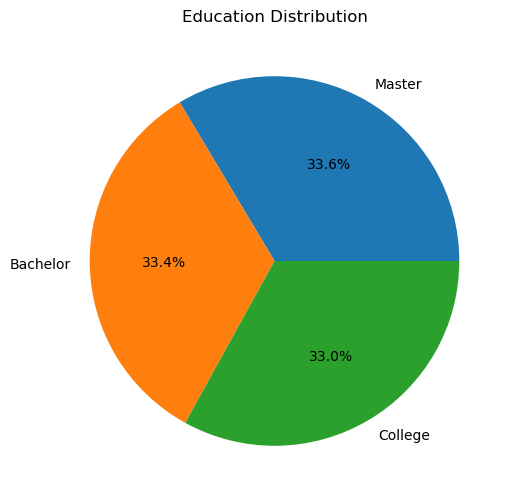

In [107]:
x1 = df['Education'].value_counts()
y1 = x1.index
plt.figure(figsize=(6, 6)) #size
plt.pie(x1, labels=y1, autopct='%1.1f%%') #string format
plt.title("Education Distribution")
plt.show()

### City Distribution
With most of the employees stemming from city C20, it could suggest 2 outcomes: 

1. The company could be based in city C20, where they tend to be more comfortable in hiring employees close to their location

2. The company could be hiring employees from city C20 due to it being a metropolis.

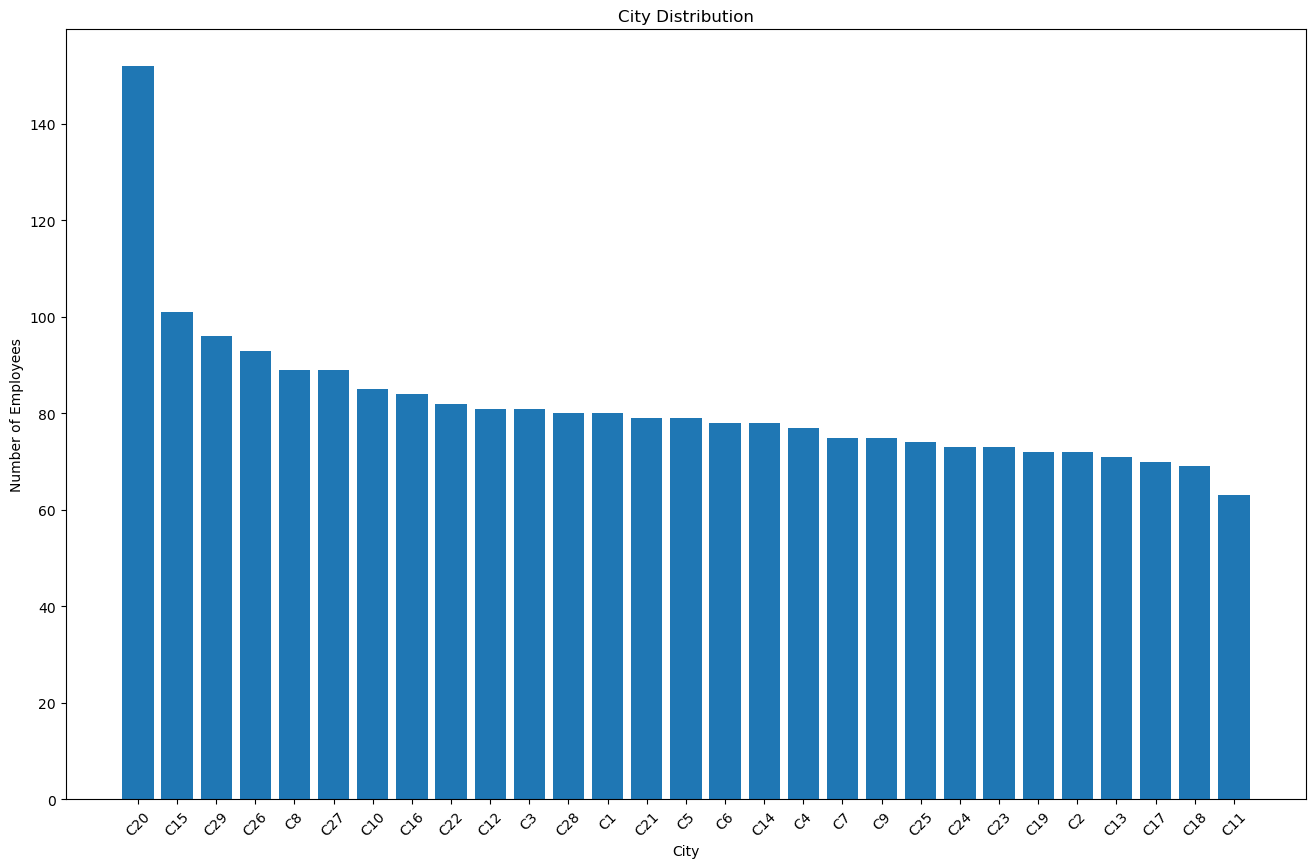

In [108]:
city_counts = df['City'].value_counts()

plt.figure(figsize=(16, 10))
plt.bar(city_counts.index, city_counts.values)

plt.title("City Distribution")
plt.xlabel("City")
plt.ylabel("Number of Employees")
plt.xticks(rotation=45) 

plt.show()


## Bivariate Analysis

### Education and Salary
With reference to the boxplot, it shows that the average salary between the various education level do not vary by a significant amount.

However, it can be seen that with a higher level of education, there is a strong correlation to greater salary as seen by a larger number of outliers receiving a higher salary for those employees that has a Master degree

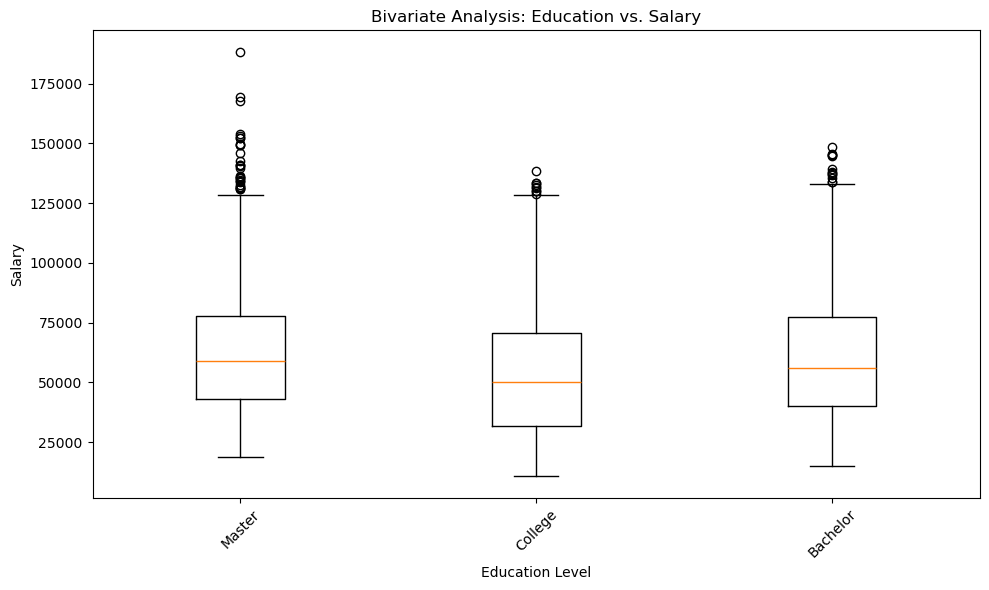

In [109]:
df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')

plt.figure(figsize=(10, 6))

education_levels = df['Education'].unique()

education_groups = [df[df['Education'] == level]['Salary'] for level in education_levels]

plt.boxplot(education_groups, tick_labels=education_levels)

plt.title('Bivariate Analysis: Education vs. Salary')
plt.xlabel('Education Level')
plt.ylabel('Salary')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Salary against Designation
With reference to the boxplot, there is a clear positive relationship between the amount of salary received and their designation as seen by the increasing mean salary of employees at a certain designation. 

However, as seen from the spread of each boxplot, it is interesting to note that having a higher designation level does not necessarily mean that one would have a higher salary

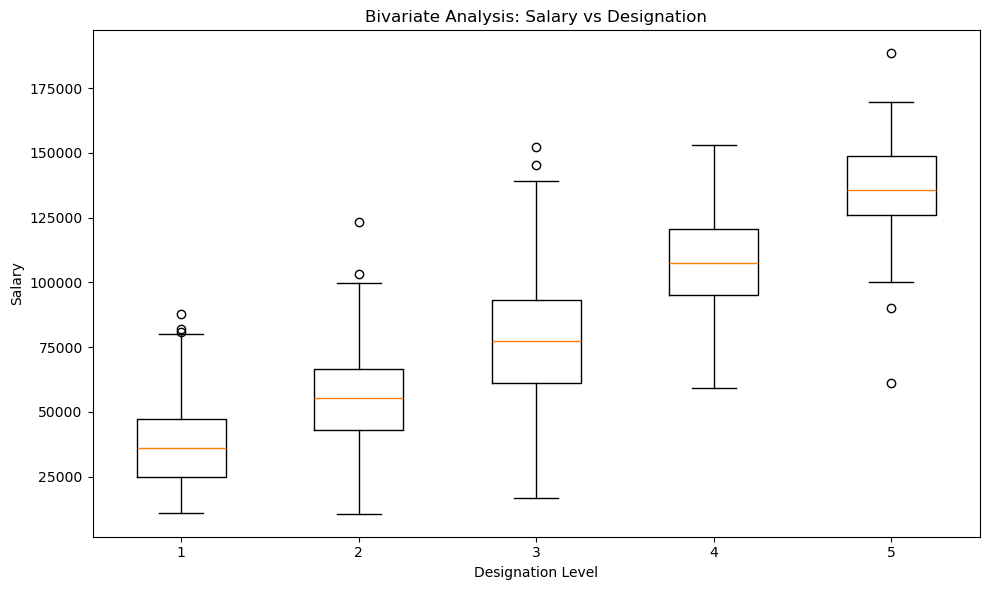

In [110]:
df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')

plt.figure(figsize=(10, 6))

designation_levels = df['Designation'].unique()

designation_groups = [df[df['Designation'] == level]['Salary'] for level in designation_levels]

plt.boxplot(designation_groups, tick_labels=designation_levels)

plt.title('Bivariate Analysis: Salary vs Designation')
plt.xlabel('Designation Level')
plt.ylabel('Salary')

plt.tight_layout()
plt.show()

### Salary against Gender
The box plot provides a comparative analysis of the salary distribution by gender.

With reference to the boxplot, both genders exhibit similar median salaries, indicating that, on average, salaries are fairly balanced. 

However, there is a significant spread in salaries, with some outliers extending well beyond the upper quartile for both categories, suggesting that a portion of employees earns substantially more than the typical salary range, probably indicating that they are holding higher designation levels in the company (as seen from the boxplot of Salary vs Designation).

Furthermore, the presence of more extreme outliers among males may imply that a higher number of men occupy higher designation level or experience greater salary variation than women.

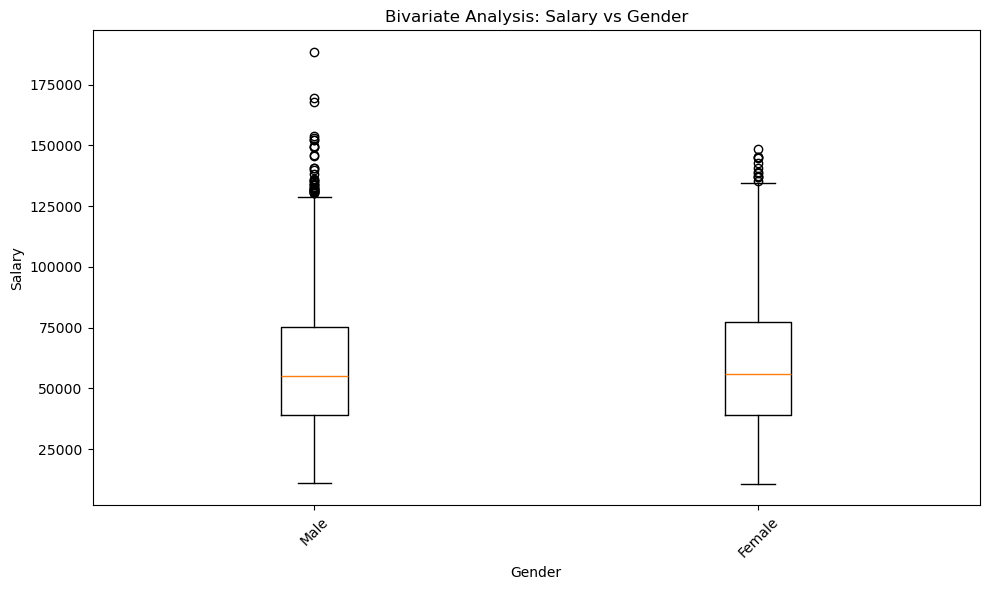

In [111]:
df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')

plt.figure(figsize=(10, 6))

genders = df['Gender'].unique()

gender_groups = [df[df['Gender'] == gender]['Salary'] for gender in genders]

plt.boxplot(gender_groups, tick_labels=genders)

plt.title('Bivariate Analysis: Salary vs Gender')
plt.xlabel('Gender')
plt.ylabel('Salary')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Salary against Age
We wanted to confirm our hypothesis that an employee being older in terms on Age would incur a higher salary. We believed that Age would equate to more experience and thus command a higher salary. 

After creating the scatterplot, the regression line does show a slight linear relationship between Salary and Age, but the salary ranges seem evenly distributed across all age ranges.

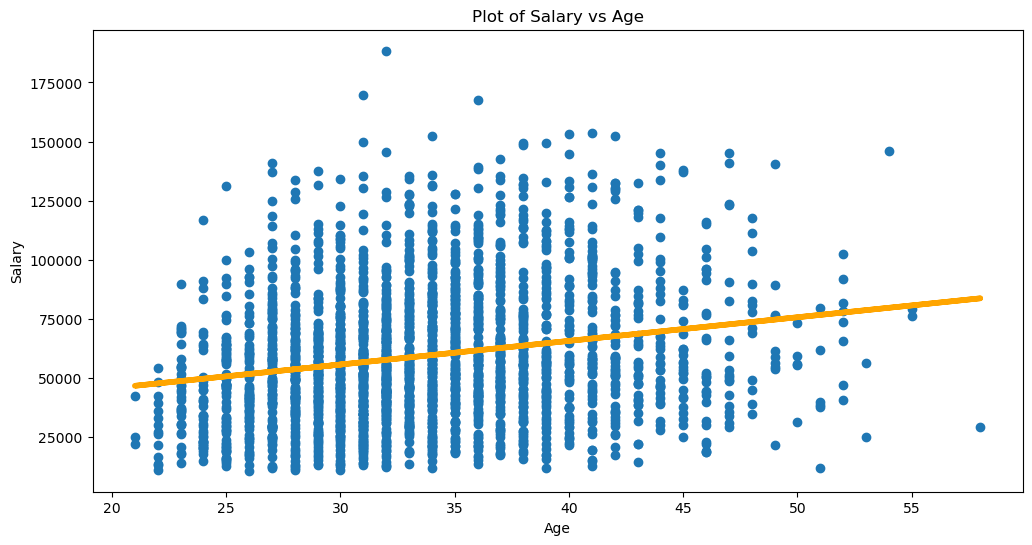

In [112]:
age = df['Age']
salary = df['Salary']
plt.figure(figsize=(12, 6))  
plt.scatter(age,salary)
plt.title("Plot of Salary vs Age")
plt.xlabel("Age")
plt.ylabel("Salary")
# drawing the regression line
line = 1000.01 * age + 25672.63
fig = plt.plot(age,line, lw=4, c='orange', label = 'Regression Line')
plt.show()

### Total_Sales_Acquired against Gender
After looking at the difference between salary of both genders, we were curious regarding the sales difference between the genders. 

With reference to boxplot, the median total sales appear to be similar for both genders, suggesting that, on average, there is no significant difference in sales performance between men and women. 

However, both distributions show a considerable number of outliers. This might be because of the large spread of the distribution of the total sales acquired as seen above. 


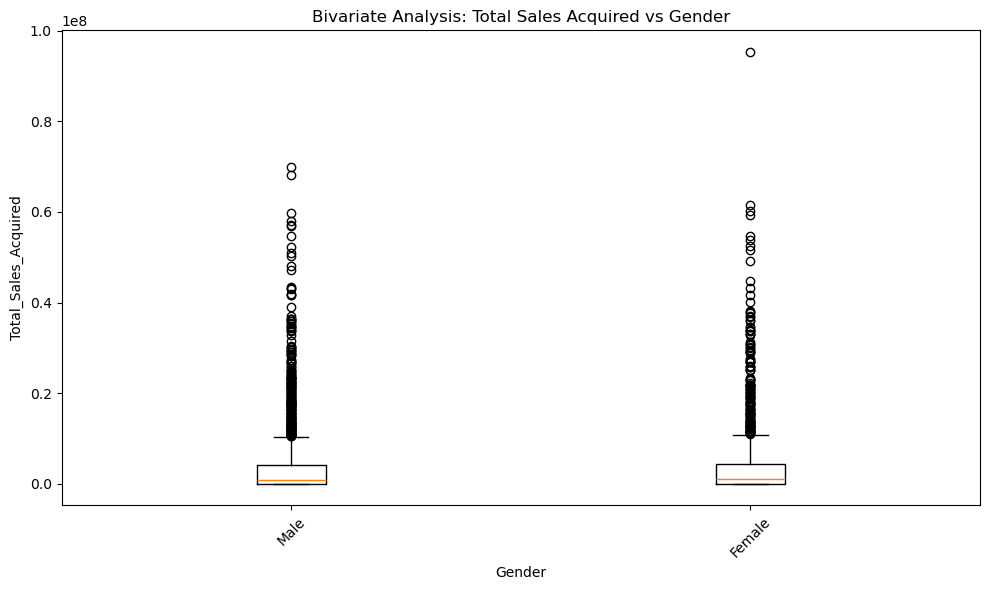

In [113]:
df['Total_Sales_Acquired'] = pd.to_numeric(df['Total_Sales_Acquired'], errors='coerce')

plt.figure(figsize=(10, 6))

genders = df['Gender'].unique()

gender_groups = [df[df['Gender'] == gender]['Total_Sales_Acquired'] for gender in genders]

plt.boxplot(gender_groups, tick_labels=genders)

plt.title('Bivariate Analysis: Total Sales Acquired vs Gender')
plt.xlabel('Gender')
plt.ylabel('Total_Sales_Acquired')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Total_Sales_Acquired against Age
We wanted to confirm our hypothesis that an employee being older in terms on Age would incur more Total Sales Acquired. We believed that Age would equate to more experience, and thus be able to perform better in terms of sales. 

After creating the scatterplot, the regression line does show a slight linear relationship between Total Sales Acquired and Age, but it seems that the age where the most Total Sales would occur is around the age of 40. This could be because as employees grow older after 40, they may be less focused on their performance due to other factors such as family or health.

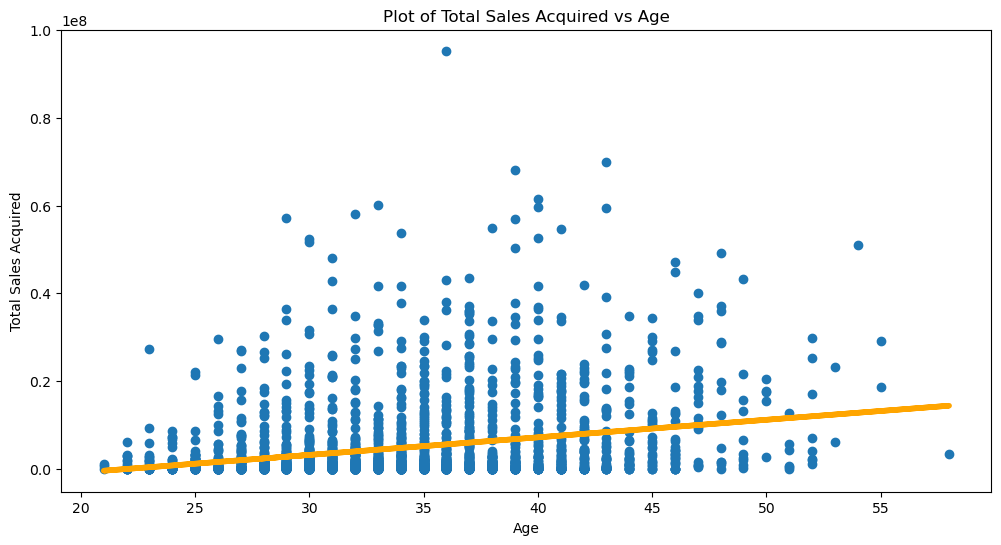

In [114]:
age = df['Age']
sales = df['Total_Sales_Acquired']
plt.figure(figsize=(12, 6))  
plt.scatter(age,sales)
plt.title("Plot of Total Sales Acquired vs Age")
plt.xlabel("Age")
plt.ylabel("Total Sales Acquired")
# drawing the regression line
line2 = 400776.15 * age + -8905221.80
fig = plt.plot(age,line2, lw=4, c='orange', label = 'Regression Line')
plt.show()

### Total_Sales_Acquired against Salary
We wanted to investigate the relationship beteeen Total Sales Acquired and Salary, and believed that they are linearly related as a better sales performance would justify an increase in salary. 

After running the data through a scatterplot, we observed that there is a linear relationship between Total Sales Acquired and Salary, but the relationship may not be as strong as we thought, as there is a significant portion of outliers where Total Sales seems to not affect the Salary.

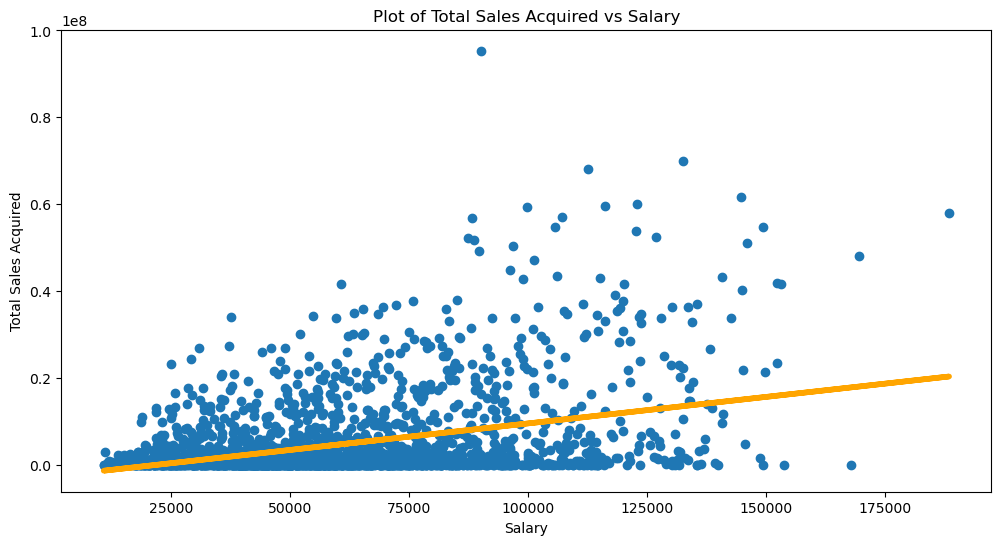

In [115]:
salary = df["Salary"]
sales = df['Total_Sales_Acquired']
plt.figure(figsize=(12, 6))  
plt.scatter(salary,sales)
plt.title("Plot of Total Sales Acquired vs Salary")
plt.xlabel("Salary")
plt.ylabel("Total Sales Acquired")
# drawing the regression line
line3 = 122.09 * salary + -2657931.02
fig = plt.plot(salary,line3, lw=4, c='orange', label = 'Regression Line')
plt.show()

### Total_Sales_Acquired against Quarterly_Rating
We wanted to investigate the relationship between Total Sales Acquired and Quarterly Rating as we believed that having a higher rating will translate to have higher total sales.

The bar chart illustrates a positive correlation between the Quarterly Rating and the Mean Total Sales Achieved. Employees with higher quarterly ratings tend to achieve greater total sales on average. This trend indicates that as ratings improve, sales also increase, demonstrating that performance ratings are a reliable reflection of each employee's sales productivity.

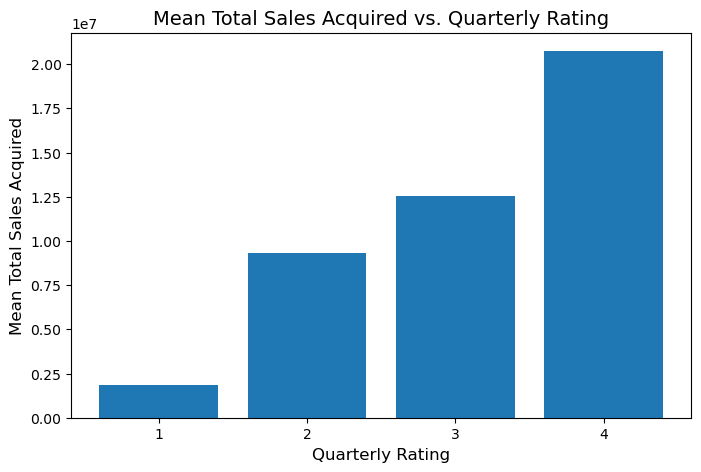

In [116]:
mean_sales = df.groupby("Quarterly_Rating")["Total_Sales_Acquired"].mean()

plt.figure(figsize=(8,5))
plt.bar(mean_sales.index, mean_sales.values)

plt.xlabel("Quarterly Rating", fontsize=12)
plt.ylabel("Mean Total Sales Acquired", fontsize=12)
plt.title("Mean Total Sales Acquired vs. Quarterly Rating", fontsize=14)
plt.xticks(mean_sales.index)  # Ensure x-axis labels match the rating values

plt.show()

### Total_Sales_Acquired against Designation_Level
We wanted to investigate the relationship between Total Sales Acquired and Designation as we believed that they are related as a higher the designation will reflect a greater total sales they made. 

The bar chart illustrates the relationship between total sales and employee designation levels. It shows a clear upward trend, indicating that as designation levels increase, total sales also rise. Employees in designation level 1 have the lowest total sales, while those in designation level 5 achieve the highest sales. This suggests that higher designations, which likely correlate with increased experience, responsibilities, and authority, contribute to improved sales performance.

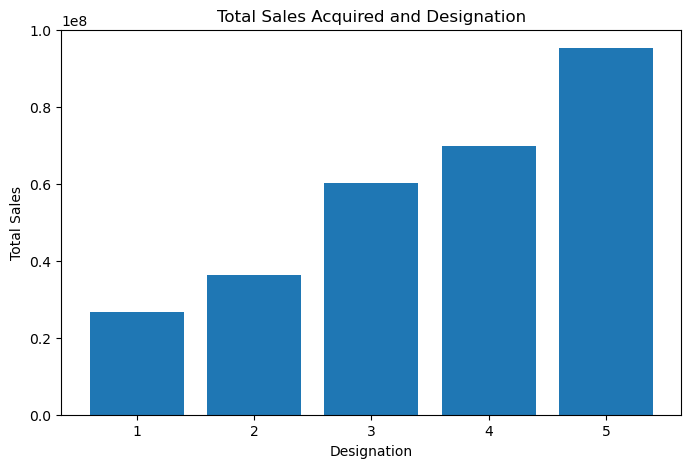

In [117]:
plt.figure(figsize=(8,5))
plt.bar(df['Designation'],df['Total_Sales_Acquired'])
plt.title("Total Sales Acquired and Designation")
plt.xlabel("Designation")
plt.ylabel("Total Sales")
plt.show()

## Part II: Modeling

### 1. Problem formulation [15% of Part II]

**a.** Formulate one regression problem and one classification based on the dataset, in **no more than 50 words**.

Salary is a key factor to employee retention, appropriately portraying the company's ability to recruit well-rounded professionals. We consider this as a regression issue. (cont'd w/ classification)

Employee designation level plays an important role in determining employee responsibilities, salary, and promotions, but companies may lack efficient ways to predict and employee's designation level based on various attributes.

**b.** State which problem (regression or classification) you would be investigating and why, in **no more than 20 words**.

We will choose to tackle the classification problem of categorising the employees by designation level. The goal of this project is to create a classification model using the demographic information provided by the dataset can forecast an employee's designation level.

**c.** Clearly specify the dependent variable you are predicting, and its significance, in **no more than 20 words**.

The objective is to train models that can use the dependent variable of designation level to categorize workers into correct existing designation levels.

### 2. Model training [30% of Part II]

**a.** Perform feature selection. For each variable, decide if you want to include it as a feature and provide a justification. You may leverage on your analysis in Part I: EDA and/or perform additional analysis.

**Response.** 

**b.** Split the dataset into train and test sets. Describe how you split step by step.

**Response.** 

**c.** State the model(s) you will train, and explain your choice(s), in **no more than 50 words per model**. You only need to
train one model, but if you do train more models, limit yourself to no more than three---Grading is based on the validity and soundness of your model, rather than the quantity.

**Response.** 

**d.** For each model, perform the training, and report the trained parameters and the training scores, if applicable. 

**Response.** 

## Feature Selection

We realised that some of our variables were considered numerical instead of categorical (join designation for example) due to them being a value (1, 2 etc). Thus we changed the values to strings to convert our data to categorical.

In [118]:
# converting to categorical features
df["Join_Designation"] = df["Join_Designation"].astype(str)
df["Designation"] = df["Designation"].astype(str)
df["Quarterly_Rating"] = df["Quarterly_Rating"].astype(str)

# splitting the into numerical and categorical
datatypes = df.dtypes
categorical_features = datatypes[datatypes=="object"].index
numerical_features = datatypes[datatypes!="object"].index
df

,Date,Emp_ID,Age,Gender,City,Education,Salary,Join_Date,Last_Work_Date,Join_Designation,Designation,Total_Sales_Acquired,Quarterly_Rating,Current_Staff
0,1/3/2016,1,28,Male,C23,Master,57387,24/12/2015,11/03/2016,1.0,1,1715580,2,No
1,1/12/2017,2,31,Male,C7,Master,67016,06/11/2017,01/12/2017,1.0,2,0,1,Yes
2,1/4/2017,4,43,Male,C13,Master,65603,07/12/2016,27/04/2017,2.0,2,350000,1,No
3,1/3/2016,5,29,Male,C9,College,46368,09/01/2016,07/03/2016,1.0,1,120360,1,No
4,1/12/2017,6,31,Female,C11,Bachelor,80874,31/07/2017,01/12/2017,3.0,3,1265000,2,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,1/12/2017,2784,34,Male,C24,College,82815,15/10/2012,01/12/2017,2.0,3,21748820,4,Yes
2377,1/10/2017,2785,34,Female,C9,College,12105,28/08/2017,28/10/2017,1.0,1,0,1,No
2378,1/9/2016,2786,45,Male,C19,College,35370,31/07/2015,22/09/2016,2.0,2,2815090,1,No
2379,1/6/2016,2787,28,Female,C20,Master,69498,21/07/2015,20/06/2016,1.0,1,977830,1,No


In [119]:
print("numerical_features")
numerical_features

numerical_features


Index(['Emp_ID', 'Age', 'Salary', 'Total_Sales_Acquired'], dtype='object')

In [120]:
print("categorical_features")
categorical_features

categorical_features


Index(['Date', 'Gender', 'City', 'Education', 'Join_Date', 'Last_Work_Date',
       'Join_Designation', 'Designation', 'Quarterly_Rating', 'Current_Staff'],
      dtype='object')

### Categorical Variables

First, we investigate the distribution of each variable by plotting barplots as below

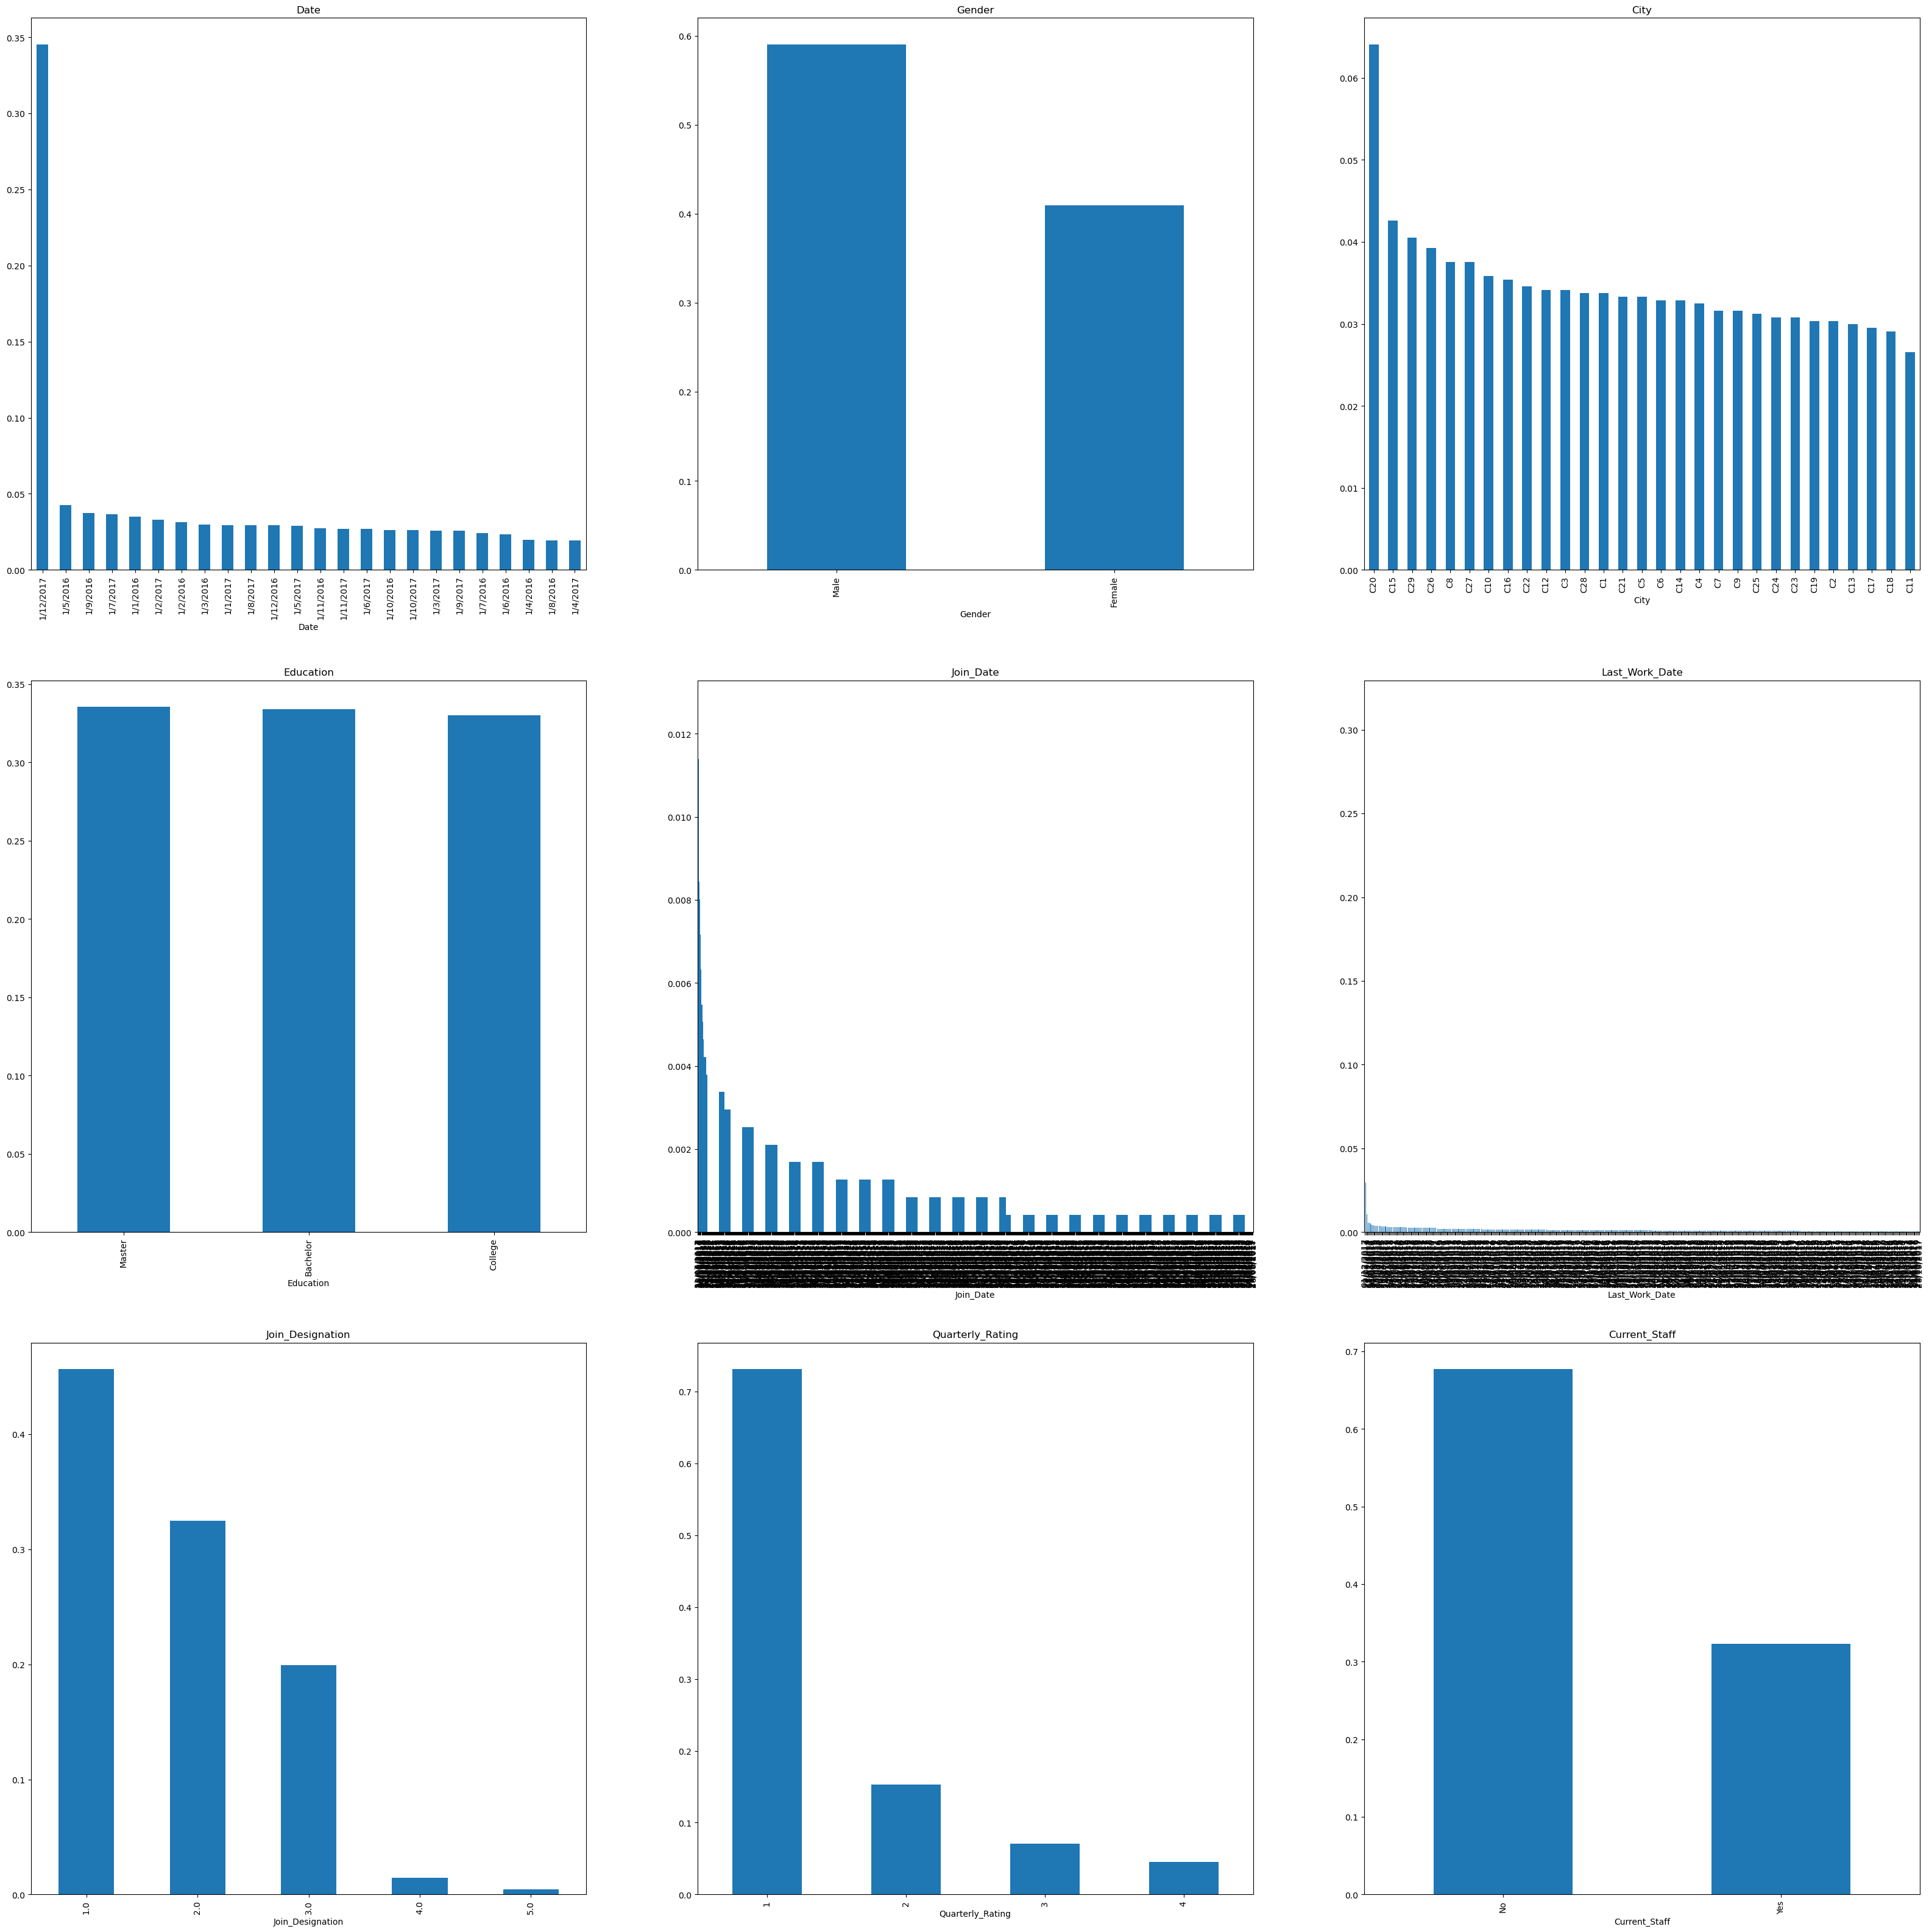

In [121]:
n = len(categorical_features)

r, c = 3, 3
fig, ax = plt.subplots(r, c, figsize=(40, 40))

count = 1
for i in range(n):
    if (categorical_features[i] == "Designation"):
        continue
    feature = categorical_features[i]
    ax = plt.subplot(r,c,count)
    count += 1
    ax.set_title(feature)
    df[feature].value_counts(normalize=True).plot(kind='bar')

plt.show()

Based on the boxplots, we can see that the Join_Date and Last_Work_Date on their own do not bring much value to our analysis. We address this by finding the Number_Of_Working_Days by subtracting Join_Date from Last_Work_Date. 

Furthermore, many of our variables have a dominant value. We decided not to select features where its mode has a frequency of more than 50%, as they are likely to have little explanatory power on the variation of `Salary`.

We removed the Date feature as we found it to be irrelevant to the Salary to be determined. (Since the date is simply the date the data was measured, and has no effect on the variables themselves)

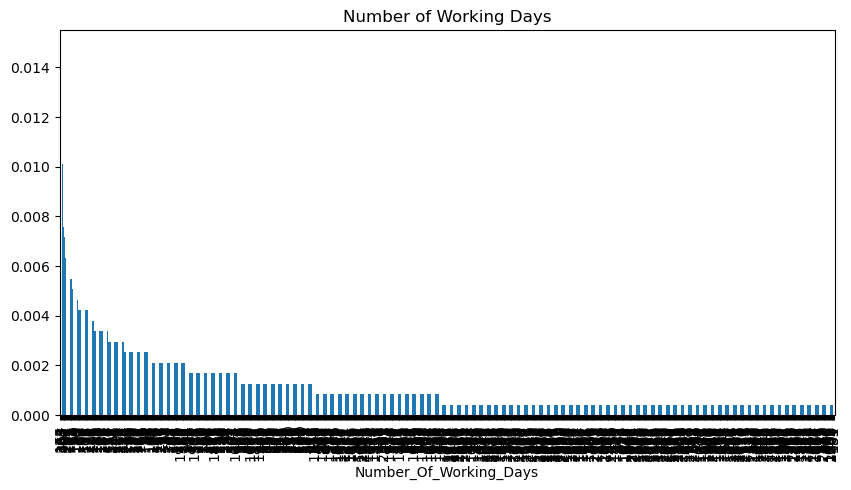

In [122]:
df['Join_Date'] = pd.to_datetime(df['Join_Date'], format='%d/%m/%Y', errors='coerce')
df['Last_Work_Date'] = pd.to_datetime(df['Last_Work_Date'], format='%d/%m/%Y', errors='coerce')
df["Number_Of_Working_Days"] = (df["Last_Work_Date"] - df["Join_Date"]).dt.days

# Convert the estimated join date back to the original format
df['Join_Date'] = df['Join_Date'].dt.strftime('%d/%m/%Y')
df['Last_Work_Date'] = df['Last_Work_Date'].dt.strftime('%d/%m/%Y')

# adding the number of working days into the numerical list
datatypes = df.dtypes
numerical_features = datatypes[datatypes!="object"].index

fig, ax = plt.subplots(1, 1, figsize=(10, 5))  # Correct way to create figure and axis
ax.set_title("Number of Working Days")
df["Number_Of_Working_Days"].value_counts(normalize=True).plot(kind='bar', ax=ax)
plt.show()

In [123]:
# get 'important' categorical features i.e. those with mode having freq < 50%

categorical_important = []

for feature in categorical_features:
    if (feature == "Date" or feature == "Join_Date" or feature == "Last_Work_Date" or feature == "Designation"):
        continue 
    highest = df[feature].value_counts(normalize=True).iloc[0]
    if highest<0.5:
        categorical_important.append(feature)
print(f"Variables with mode contributing <50% are : {categorical_important}")

Variables with mode contributing <50% are : ['City', 'Education', 'Join_Designation']


Based on the criteria we would keep these three categorical variables.  We next look into how `Deisgnation` is related to these variables.  For each categorical variable, we plot a stacked bar plot and see the distribution of `Designation` with respect to the categorical variable

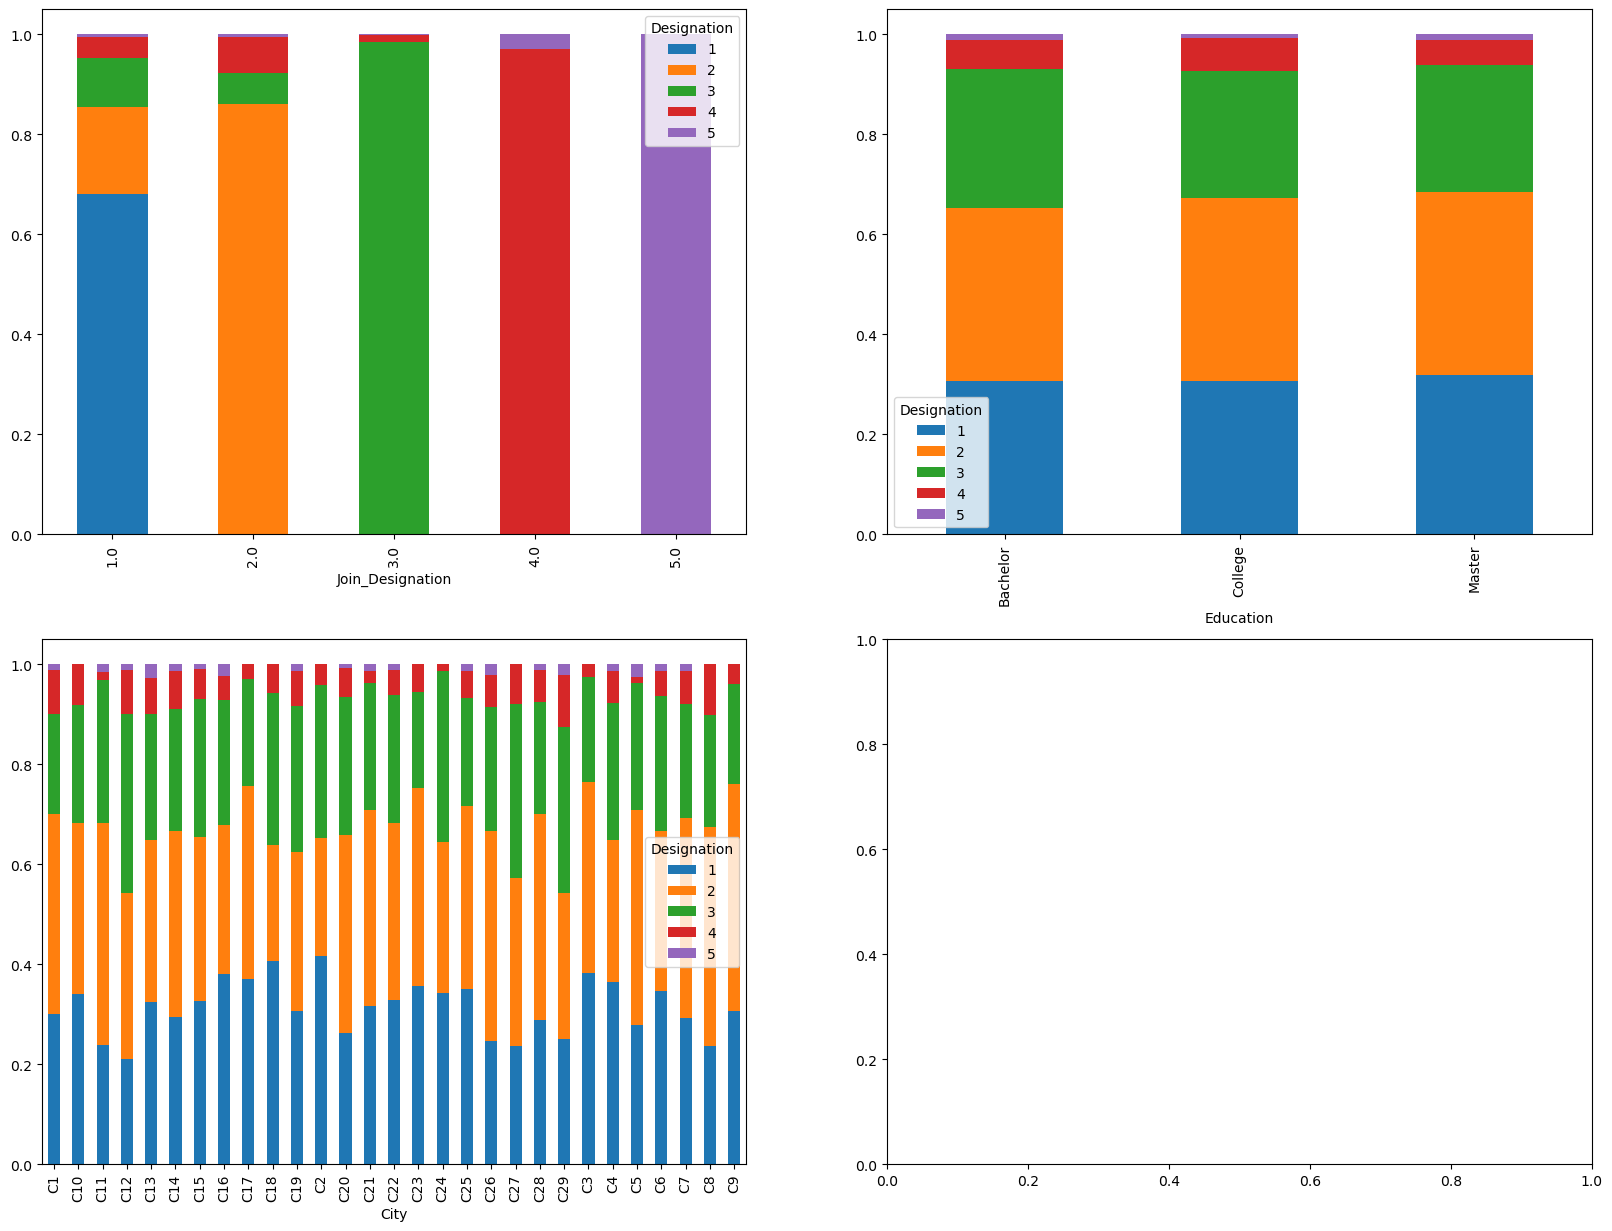

In [124]:
# n = len(categorical_important)

# r, c = 2,2
# fig, ax = plt.subplots(r, c, figsize=(20,15))

# for i in range(n):
#     feature = categorical_important[::-1][i]
#     ax = plt.subplot(r,c,i+1)
#     df[[feature,'Salary']].boxplot(by=feature, ax=ax, rot=90)

n = len(categorical_important)
r, c = 2,2
fig, ax = plt.subplots(r, c, figsize=(20,15))

for i in range(n):
    feature = categorical_important[::-1][i]
    ax = plt.subplot(r,c,i+1)
    pd.crosstab(df[feature], df["Designation"], normalize="index").plot.bar(stacked=True, ax=ax)


**** FROM PREVIOUS REGRESSION ****


The salary distribution across various categorical factors, such as Designation, Job Designation, Education, City, and Date, is displayed using box plots. The relative wage trends, variances, and possible discrepancies across the organization are displayed in each plot.

addons to below the boxplot (salary v all the variables)
Given the boxplots above,
1. There is a noticeable difference in the amount of employees, with a Master's qualification, drawing salaries above the upper limit.
2. There is a noticeable increase in the Salary medians as designation levels increase.

The other variables not mentioned seem to have a minute relationship with Salary. There are some outliers, particularly in the join date and city, that seem to be indictative of a possibility that there are have been instances where Highly Skilled workers were employed as assumingly low-level employees or that the corporation has faced salary discrepancy.

Based on a visual observation we noted the following:
- For `Join_Designation`, those who have higher `Join_Designation` have a higher proportion of them having higher `Designation` than those with lower `Join_Designation`

For the other variables, a visual inspection does not reveal any potential relationship to `Designation`

Hence based on an EDA on the categorical variables, we will only keep `Join_Designation`. Furthermore, we would encode the categorical values with a numerical value. We could do that because `Join_Designation` is ordinal, meaning there is a natural order attached to the values.

In [125]:
# def encode_education(value):
#     if value=="Master":
#         return 2
#     elif value=="Bachelor":
#         return 1
#     else:
#         return 0

# df["Education_Encoded"] = df["Education"].apply(encode_education)

df["Join_Designation"] = df["Join_Designation"].astype(float)

categorical_features_selected = ["Join_Designation"]

### Numerical Variables

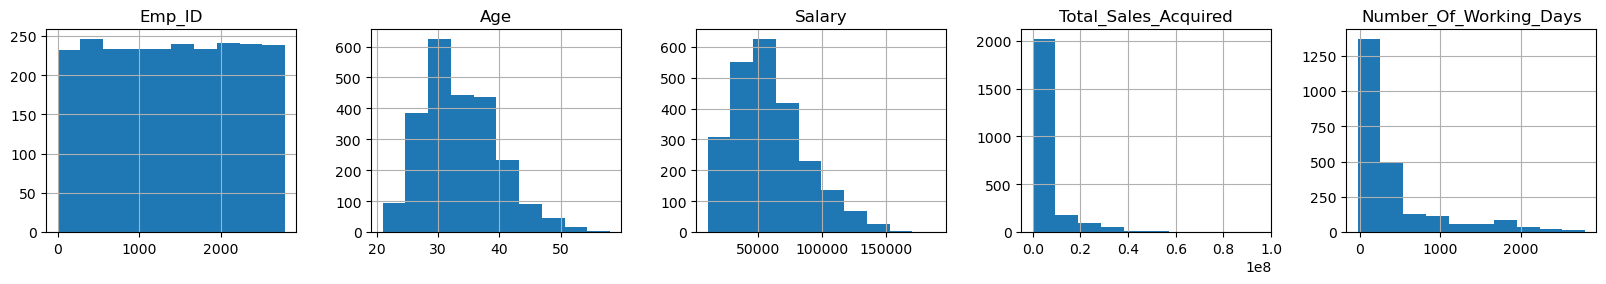

In [126]:
df[numerical_features].hist(layout=(9,5), figsize=(20,30))

plt.show()

- Emp_ID is an index
- Age has good variation (resembles Gaussian Distribution)
- Salary is the dependent variable
- Total_Sales_Acquired

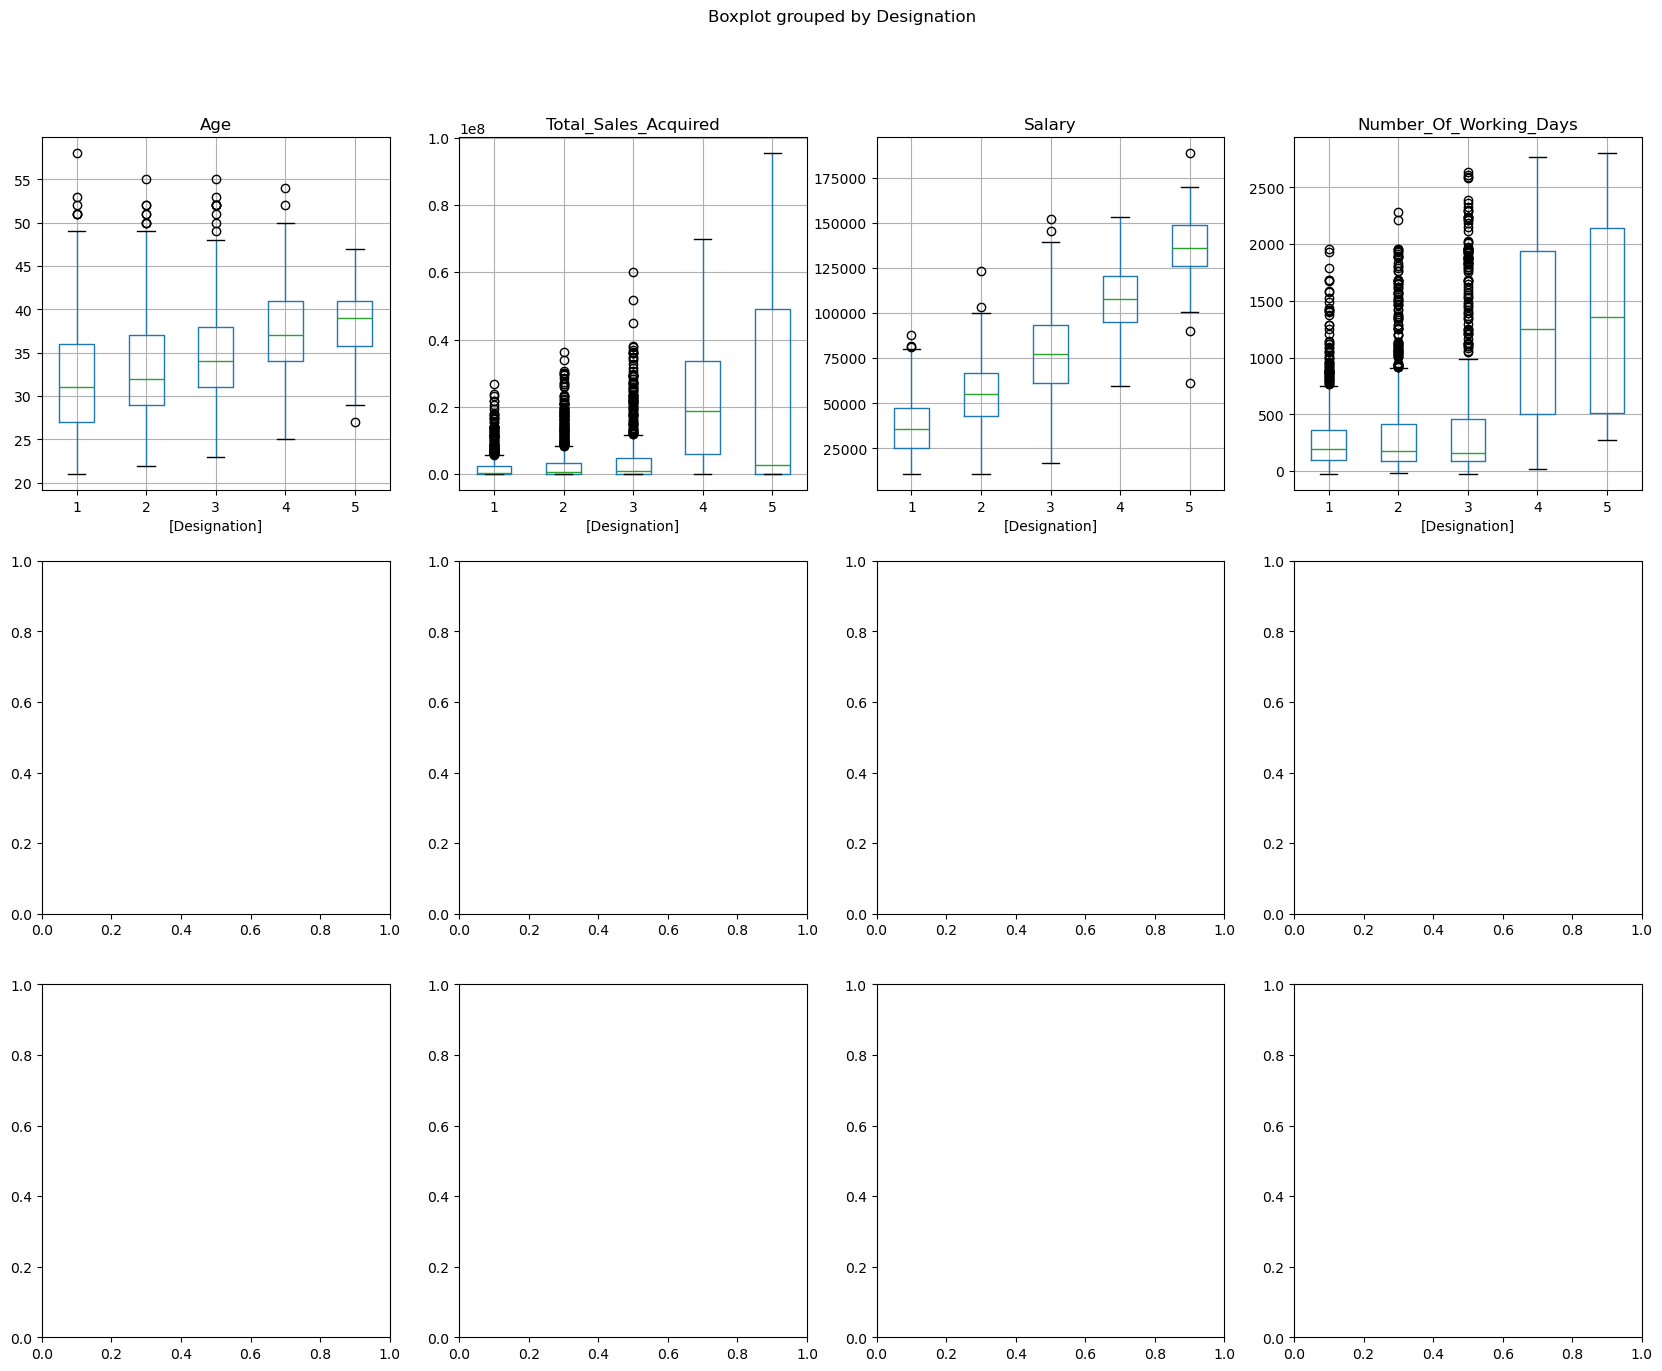

In [127]:
features_selected = ["Age", "Total_Sales_Acquired", "Salary", "Number_Of_Working_Days"]

n = len(features_selected)

r, c = 3,4
fig, ax = plt.subplots(r, c, figsize=(20,16))

for i in range(n):
    feature = features_selected[i]
    ax = plt.subplot(r,c,i+1)
    ax.set_title(feature)
    df[['Designation',feature]].boxplot(by='Designation', ax=ax)

plt.show()

The next step is to see if dependent variable `SalePriceClass` is correlated with the features. We will do this only visually in this case - if the median values along with the IQR increase or decrease as we move from one class to another class, then we consider that the feature is corrleated to 'SalePriceClass'  

Based on the criteria, the selected features are 'Overal Qual', 'Total Bsmt SF', 'Gr Liv Area', 'Garage Area', 'Age' and 'Total Flr SF'

We also want to check that our selected features are not correlated amongst each other.  Any feature that is correlated to others are in a sense *redundant*, hence we would remove them.  Again we could do a quick visual check and see that, for example, `Gr Liv Area` is highly correlated to `Total Flr SF` and hence either is a good candidate to be removed.  Here we have also written a function to eliminate the feature that is the most correlated one by one, untill all features are not correlated.

In [128]:
features_selected = ["Age", "Total_Sales_Acquired", "Salary", "Number_Of_Working_Days"]
df[features_selected].corr()

,Age,Total_Sales_Acquired,Salary,Number_Of_Working_Days
Age,1.000000,0.263256,0.209792,0.309561
Total_Sales_Acquired,0.263256,1.000000,0.379851,0.664766
Salary,0.209792,0.379851,1.000000,0.329265
Number_Of_Working_Days,0.309561,0.664766,0.329265,1.000000


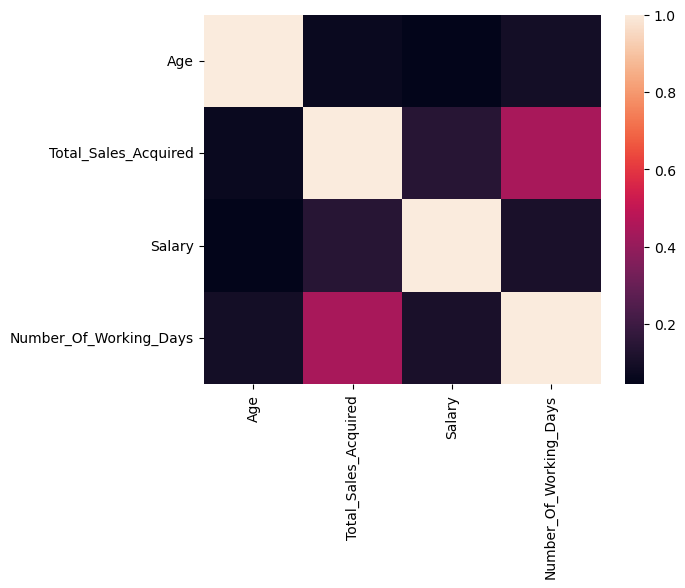

In [129]:
r2 = df[features_selected].corr()**2
sns.heatmap(r2)
plt.show()

The next step is to see if dependent variable `SalePrice` is correlated with our independent variables. We could do it with a correlation table or via correlation heatmap as above.  Note that in the correlation heatmap above, we calculate $r^2$ instead.  The darker the shade the lower the correlation.  We can see, for example, that `Lot Area`, `Lot Frontage` are not quite correlated with `SalePrice`.  Below we write a function to select the features based on a threshold.

In [130]:
# features_selected = ['Overall Qual', 'Total Bsmt SF', 'Gr Liv Area', 'Garage Area', 'Age', 'Total Flr SF']
# update this
print(f"updated selected features: {features_selected}")

updated selected features: ['Age', 'Total_Sales_Acquired', 'Salary', 'Number_Of_Working_Days']


We also want to check that our selected features are not correlated amongst each other.  Any feature that is correlated to others are in a sense *redundant*, hence we would remove them.  Again we could do a quick visual check and see that, for example, `Gr Liv Area` is highly correlated to `Total Flr SF` and hence either is a good candidate to be removed.  Here we have also written a function to eliminate the feature that is the most correlated one by one, untill all features are not correlated.

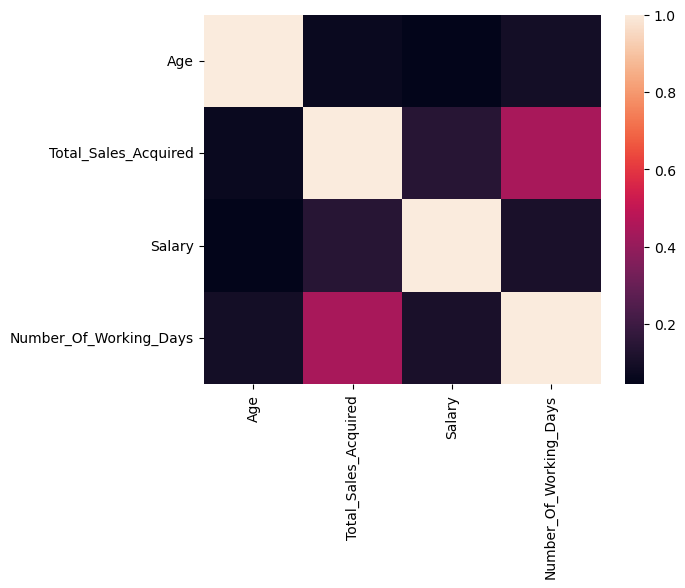

In [131]:
r2 = df[features_selected].corr()**2
sns.heatmap(r2)
plt.show()

In [132]:
# get the feature that has the most number of features
# it is correlated with, beyond certain threshold

def most_corr_feature(data, threshold):
    r2_matrix = abs(data.corr())
    count = r2_matrix[r2_matrix>threshold].count()
    return count.sort_values(ascending=False).index[0]

# return true if all the features are uncorrelated,
# as defined by a threshold

def all_features_uncorr(data, threshold):
    r2_matrix = abs(data.corr())
    n = len(r2_matrix)
    return r2_matrix[r2_matrix>threshold].count().sum()==n

# get a set of uncorrelated features

def get_uncorr_features(data, threshold):
    features = data.columns.tolist()
    while all_features_uncorr(data[features], threshold) == False:
        most_corr_fea = most_corr_feature(data[features], threshold)
        features.remove(most_corr_fea)
    return features

In [133]:
numerical_features_selected = get_uncorr_features(df[features_selected], 0.5)
print(f"Selected numerical features : {numerical_features_selected}")

Selected numerical features : ['Age', 'Salary', 'Number_Of_Working_Days']


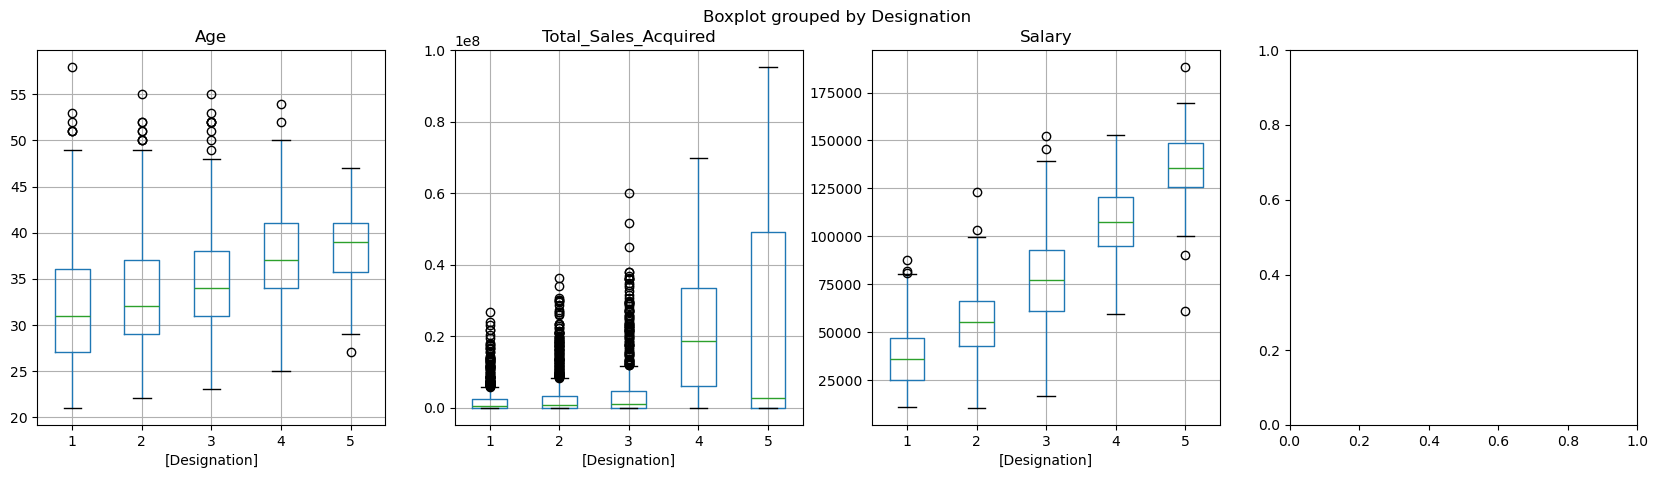

In [135]:
# TODO
n = len(numerical_features_selected)

r, c = 1,4
fig, ax = plt.subplots(r, c, figsize=(20,5))

for i in range(n):
    feature = features_selected[i]
    ax = plt.subplot(r,c,i+1)
    ax.set_title(feature)
    df[['Designation',feature]].boxplot(by='Designation', ax=ax)

plt.show()

In [ ]:
features_selected = categorical_features_selected + numerical_features_selected
features_selected

['Education_Encoded',
 'Designation',
 'Join_Designation',
 'Number_Of_Working_Days']

### 3. Model evaluation and selection [30% of Part II]

**a.** For each model, predict the response variable on the test set.

**Response.** 

**b.** Describe the metric you use to evaluate your model(s). Report the test scores for each model.

**Response.** 

**c.** If you trained more than one model, identify the final model you would choose for the prediction task, and explain your choice, **in no more than 50 words**.

**Response.** 

### 4. Findings and conclusion [20% of Part II]

**a.** Interpret what your model is implying, and summarize any insight you have drawn from the project. Explain if it is consistent with intuition, and if not, provide a plausible justification. Limit your entire response to **50 words**.

**Response.** 

**b.** Share any lesson you have learned from the project, in **no more than 50 words**.

**Response.** 

### 5. Non-technical protocol [5% of Part II]

**a.** Describe the detailed contribution of each team member, including both the tangible (e.g., implementation, testing, writing) and intangible (e.g., generating ideas, planning, leadership) efforts.

**Response.** 

**b.** List any references and sources you have cited.

**Response.** 